Also here is a single notebook that that goes through an entire analysis of trp-cage using the standard MSM workflow. This is before our SRV analysis stuff so it is not immediately relevant to the paper, but has the advantage of showing all of the cross validation steps etc in a single place without any jobs run on the cluster. So it’s easier to follow in that sense.

In addition to this, PyEmma just released with their latest version (2.5.5) a pretty thorough walkthrough and analysis for pentapeptide which can be found here http://www.emma-project.org/latest/tutorial.html#jupyter-notebook-tutorials I follow their practices pretty closely though before this notebook came out, based on Noe’s previously discussed best pratices.

# Optimal Markov State Model (MSM) construction

In this notebook we will be constructing an optimal MSM and analyzing it.

In [1]:
%matplotlib inline 
import os
import pyemma
import pyemma.coordinates as coor
import pyemma.plots as mplt
import nglview as nv
import numpy as np 
from itertools import combinations
import mdtraj as md
from scipy import spatial
import matplotlib.pyplot as plt
plt.rcParams.update({
    "font.size" : 14, 
    "font.family" : "serif"
})

/home/hsidky/miniconda3/envs/dnets2/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/hsidky/miniconda3/envs/dnets2/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## Define shared variables and functions

In [2]:
#trj_dir = "/Users/hsidky/Data/DESRES-Trajectory_2JOF-0-protein/2JOF-0-protein"
trj_dir = "/home/hsidky/Data/DESRES-Trajectory_2JOF-0-protein/2JOF-0-protein"

In [3]:
trj_file = os.path.join(trj_dir, "trp-cage_rmsdmin.dcd")
raw_file = os.path.join(trj_dir, "trp-cage_raw.dcd")
pdb_file = os.path.join(trj_dir, "2JOF-0-protein.pdb")

In [4]:
trj = md.load(trj_file, top=pdb_file)
ref = md.load("2jof.pdb")

/home/hsidky/miniconda3/envs/dnets2/lib/python3.6/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '


In [5]:
ca_atoms = trj.topology.select("name CA")
ref_ca_atoms = ref.topology.select("name CA")

In [6]:
trj_ca_slice = trj.atom_slice(ca_atoms)
ref_ca_slice = ref.atom_slice(ref_ca_atoms)

In [7]:
# some helper funcs
def average_by_state(dtraj, x, nstates):
    assert(len(dtraj) == len(x))
    N = len(dtraj)
    res = np.zeros((nstates))
    for i in range(nstates):
        I = np.argwhere(dtraj == i)[:,0]
        res[i] = np.mean(x[I])
    return res

def avg_by_set(x, sets):
    # compute mean positions of sets. This is important because of some technical points the set order
    # in the coarse-grained TPT object can be different from the input order.
    avg = np.zeros(len(sets))
    for i in range(len(sets)):
        I = list(sets[i])
        avg[i] = np.mean(x[I])
    return avg

## Compute collective variables

In [8]:
rmsd_cv = md.rmsd(
            trj_ca_slice, 
            ref_ca_slice, 
            frame=0)

In [9]:
masses = np.array([atom.element.mass for atom in trj.top.atoms])
rg_cv = md.compute_rg(trj, masses=masses)

In [10]:
import analysis

q_ref = trj[np.argmin(rmsd_cv)]
q_cv = analysis.best_hummer_q(trj, q_ref)

Number of native contacts 131


/home/hsidky/Code/nncv/trp-cage/analysis.py:53: RuntimeWarning: overflow encountered in exp
  q = np.mean(1.0 / (1 + np.exp(BETA_CONST * (r - LAMBDA_CONST * r0))), axis=1)


In [11]:
torsion_atoms = trj.topology.select("name CA and (resid 0 or resid 8 or resid 13 or resid 19)")
chiral_cv = np.sin(md.compute_dihedrals(trj, torsion_atoms.reshape((1,4))))

## Variational selection of features

First let's featurize the trajectory. We will perform variational selection using the VAMP2 score (Variational Approach to Markov Processes). This must be done at fixed lag time since [lag time cannot be used for variational model selection](https://arxiv.org/pdf/1708.08120.pdf). We will test: 


- Backbone torsions 
- $C\textrm{-}\alpha$ pairwise distances 
- Combined 1, 2, with the addition of sidechain torsions.

**Note**
I exclude torsions belonging to residues 18 and 19 (PRO) which is part of the tail. There is something very strange going on with a particular torsion there. I believe there is a very rare fluctuation (happens only twice) that occurs which corrupts the signal and results in a broken model. The TICA projection I presented last time suffered from this problem. It took quite some time to diagnose what was going on, but I eventually identified this issue. 

In [12]:
torsions_feat = coor.featurizer(pdb_file)
torsions_feat.add_backbone_torsions(cossin=True, selstr="not resid 18 and not resid 19", periodic=False)
torsions_data = coor.load(trj_file, features=torsions_feat)
labels = ["Backbone\ntorsions"]

ca_distances_feat = coor.featurizer(pdb_file)
ca_distances_feat.add_distances_ca(periodic=False)
ca_distances_data = coor.load(trj_file, features=ca_distances_feat)
labels += ["C-alpha atom\ndistances"]

combined_feat = coor.featurizer(pdb_file)
combined_feat.add_backbone_torsions(cossin=True, selstr="not resid 18 and not resid 19", periodic=False)
combined_feat.add_sidechain_torsions(cossin=True, which=["chi1"], periodic=False)
combined_feat.add_distances_ca(periodic=False)
combined_data = coor.load(trj_file, features=combined_feat)
labels += ["Combined\nfeatures"]

allatom_feat = coor.featurizer(pdb_file)
allatom_feat.add_all()
allatom_data = coor.load(trj_file, features=allatom_feat)
labels += ["XYZ\ncoordinates"]

Do 5-fold cross validation at various lagtimes.

In [47]:
from sklearn.model_selection import KFold

In [180]:
def score_cv(data, dim, lag, number_of_folds=5):
    # we temporarily suppress very short-lived progress bars
    with pyemma.util.contexts.settings(show_progress_bars=False):
        k_folds = KFold(n_splits=number_of_folds)
        scores = np.zeros(number_of_folds)
        for i, (train_index, test_index) in enumerate(k_folds.split(data)):
            vamp = coor.vamp(data[train_index], lag=lag, dim=dim, ncov_max=2)
            scores[i] = vamp.score(data[test_index])
        
    return scores

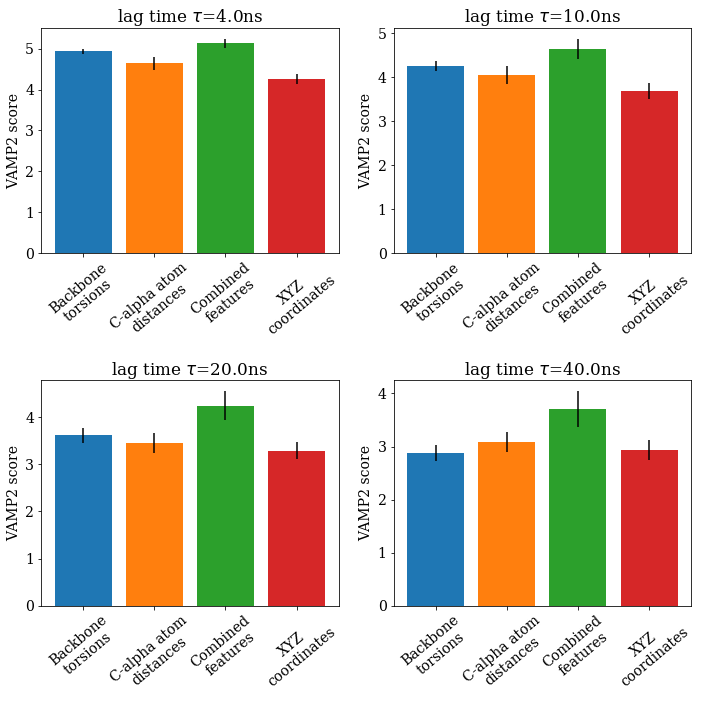

In [16]:
dim = 5

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
for ax, lag in zip(axes.flat, [2, 50, 100, 200]):
    torsions_scores = score_cv(torsions_data, lag=lag, dim=dim)
    scores = [torsions_scores.mean()]
    errors = [torsions_scores.std()]
    
    ca_distances_scores = score_cv(ca_distances_data, lag=lag, dim=dim)
    scores += [ca_distances_scores.mean()]
    errors += [ca_distances_scores.std()]
    
    combined_scores = score_cv(combined_data, lag=lag, dim=dim)
    scores += [combined_scores.mean()]
    errors += [combined_scores.std()]
    
    allatom_scores = score_cv(allatom_data, lag=lag, dim=dim)
    scores += [allatom_scores.mean()]
    errors += [allatom_scores.std()]
    
    ax.bar(labels, scores, yerr=errors, color=["C0", "C1", "C2", "C3"])
    ax.set_xticklabels(labels, rotation=40)
    ax.set_title(r"lag time $\tau$={:.1f}ns".format(lag*0.2))
    ax.set_ylabel("VAMP2 score")

    # Save for later.
    if lag == 50:
        vamp_bars_plot = dict(
            labels=labels, scores=scores, errors=errors, dim=dim, lag=lag)

fig.tight_layout()
plt.savefig("feature_crossval.png", dpi=300)
plt.show()

The combined features perform better across our selection of lag-times so we will use that moving forward.

## Variational selection of TICA lag-time, dimension, and clustering centers

In this next step, we are interested in the (a) TIC lag-time, (b) number of TIC coordinates, and (c) number of cluster centers which will produce the best MSM. Because we are optimizing with respect to MSM construction, [we can vary the lag time of TICA since it is an intermediate step](https://arxiv.org/pdf/1708.08120.pdf). Also, including all TIC coordinates within a certain variance cutoff is not necessarily the best option. [Previous work](http://pubs.acs.org/doi/10.1021/ct300878a) has shown that using only a few TIC coordinates can yield better MSMs because higher-frequency noise is essentially filtered out. 

**Note**
After constructing our MSM, we will later produce a variationally-optimal TICA projection which we can use for visualization. 

In [17]:
tica_lags = [30, 50, 200, 700, 1000]
tica_dims = [4, 5, 8, 10, 15, 20]
msm_lag = 300

In [51]:
def score_cv_msm(data, dim, lag, n_centers, msm_lag, number_of_folds=5):
    # we temporarily suppress very short-lived progress bars
    with pyemma.util.contexts.settings(show_progress_bars=False):
        k_folds = KFold(n_splits=number_of_folds)
        scores = np.zeros(number_of_folds)
        for i, (train_index, test_index) in enumerate(k_folds.split(data)):
            tica = pyemma.coordinates.tica(data=data[train_index], lag=lag, dim=dim)
            cluster = pyemma.coordinates.cluster_kmeans(tica, k=n_centers, max_iter=50, stride=10)
            msm = pyemma.msm.estimate_markov_model(cluster.dtrajs, lag=msm_lag, dt_traj="0.2 ns")
            scores[i] = msm.score(cluster.assign(tica.transform(data[test_index])), score_k=8, score_method="VAMP1")
    return scores

Completed lag time 30
Completed lag time 50
Completed lag time 200
Completed lag time 700
Completed lag time 1000


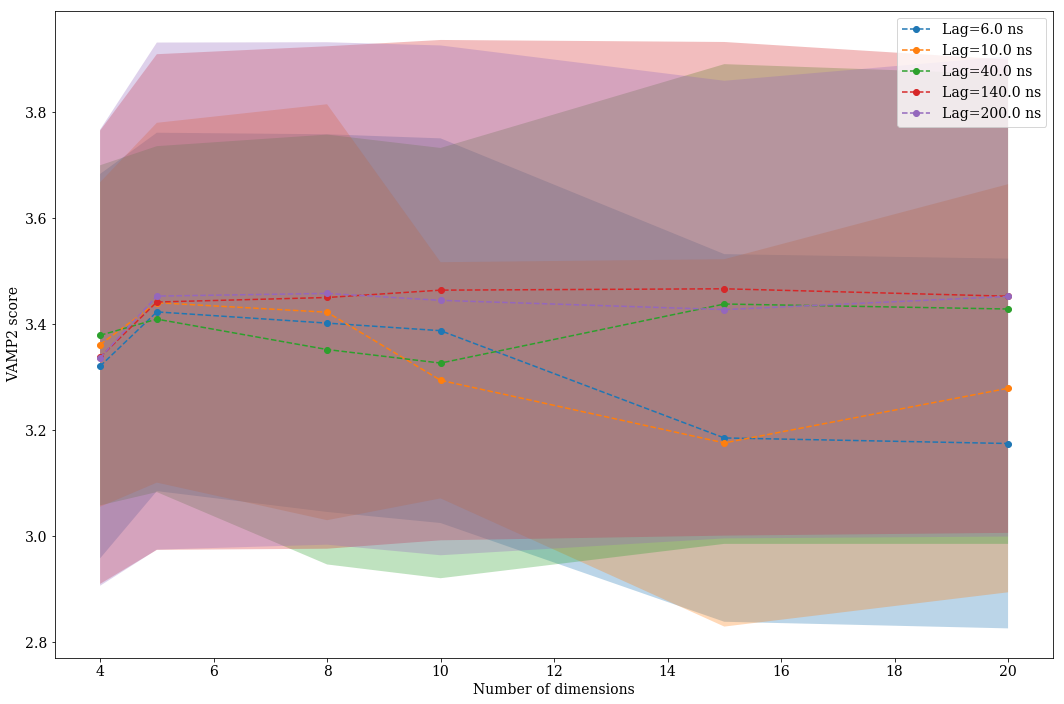

In [19]:
scores_avg = np.zeros((len(tica_lags), len(tica_dims)))
scores_err = np.zeros((len(tica_lags), len(tica_dims)))

fig, ax = plt.subplots(figsize=(15, 10))
for i, lag in enumerate(tica_lags):
    scores_ = np.array([score_cv_msm(combined_data, dim, lag, 500, msm_lag) for dim in tica_dims])
    scores = np.mean(scores_, axis=1)
    errors = np.std(scores_, axis=1, ddof=1)
    
    # Store for later.
    scores_avg[i,:] = scores
    scores_err[i,:] = errors
    
    # Plot 
    color = "C{}".format(i)
    ax.fill_between(tica_dims, scores - errors, scores + errors, alpha=0.3, facecolor=color)
    ax.plot(tica_dims, scores, "--o", color=color, label="Lag={:.1f} ns".format(lag * 0.2))
    print("Completed lag time {}".format(lag))

ax.legend()
ax.set_xlabel("Number of dimensions")
ax.set_ylabel("VAMP2 score")
fig.tight_layout()

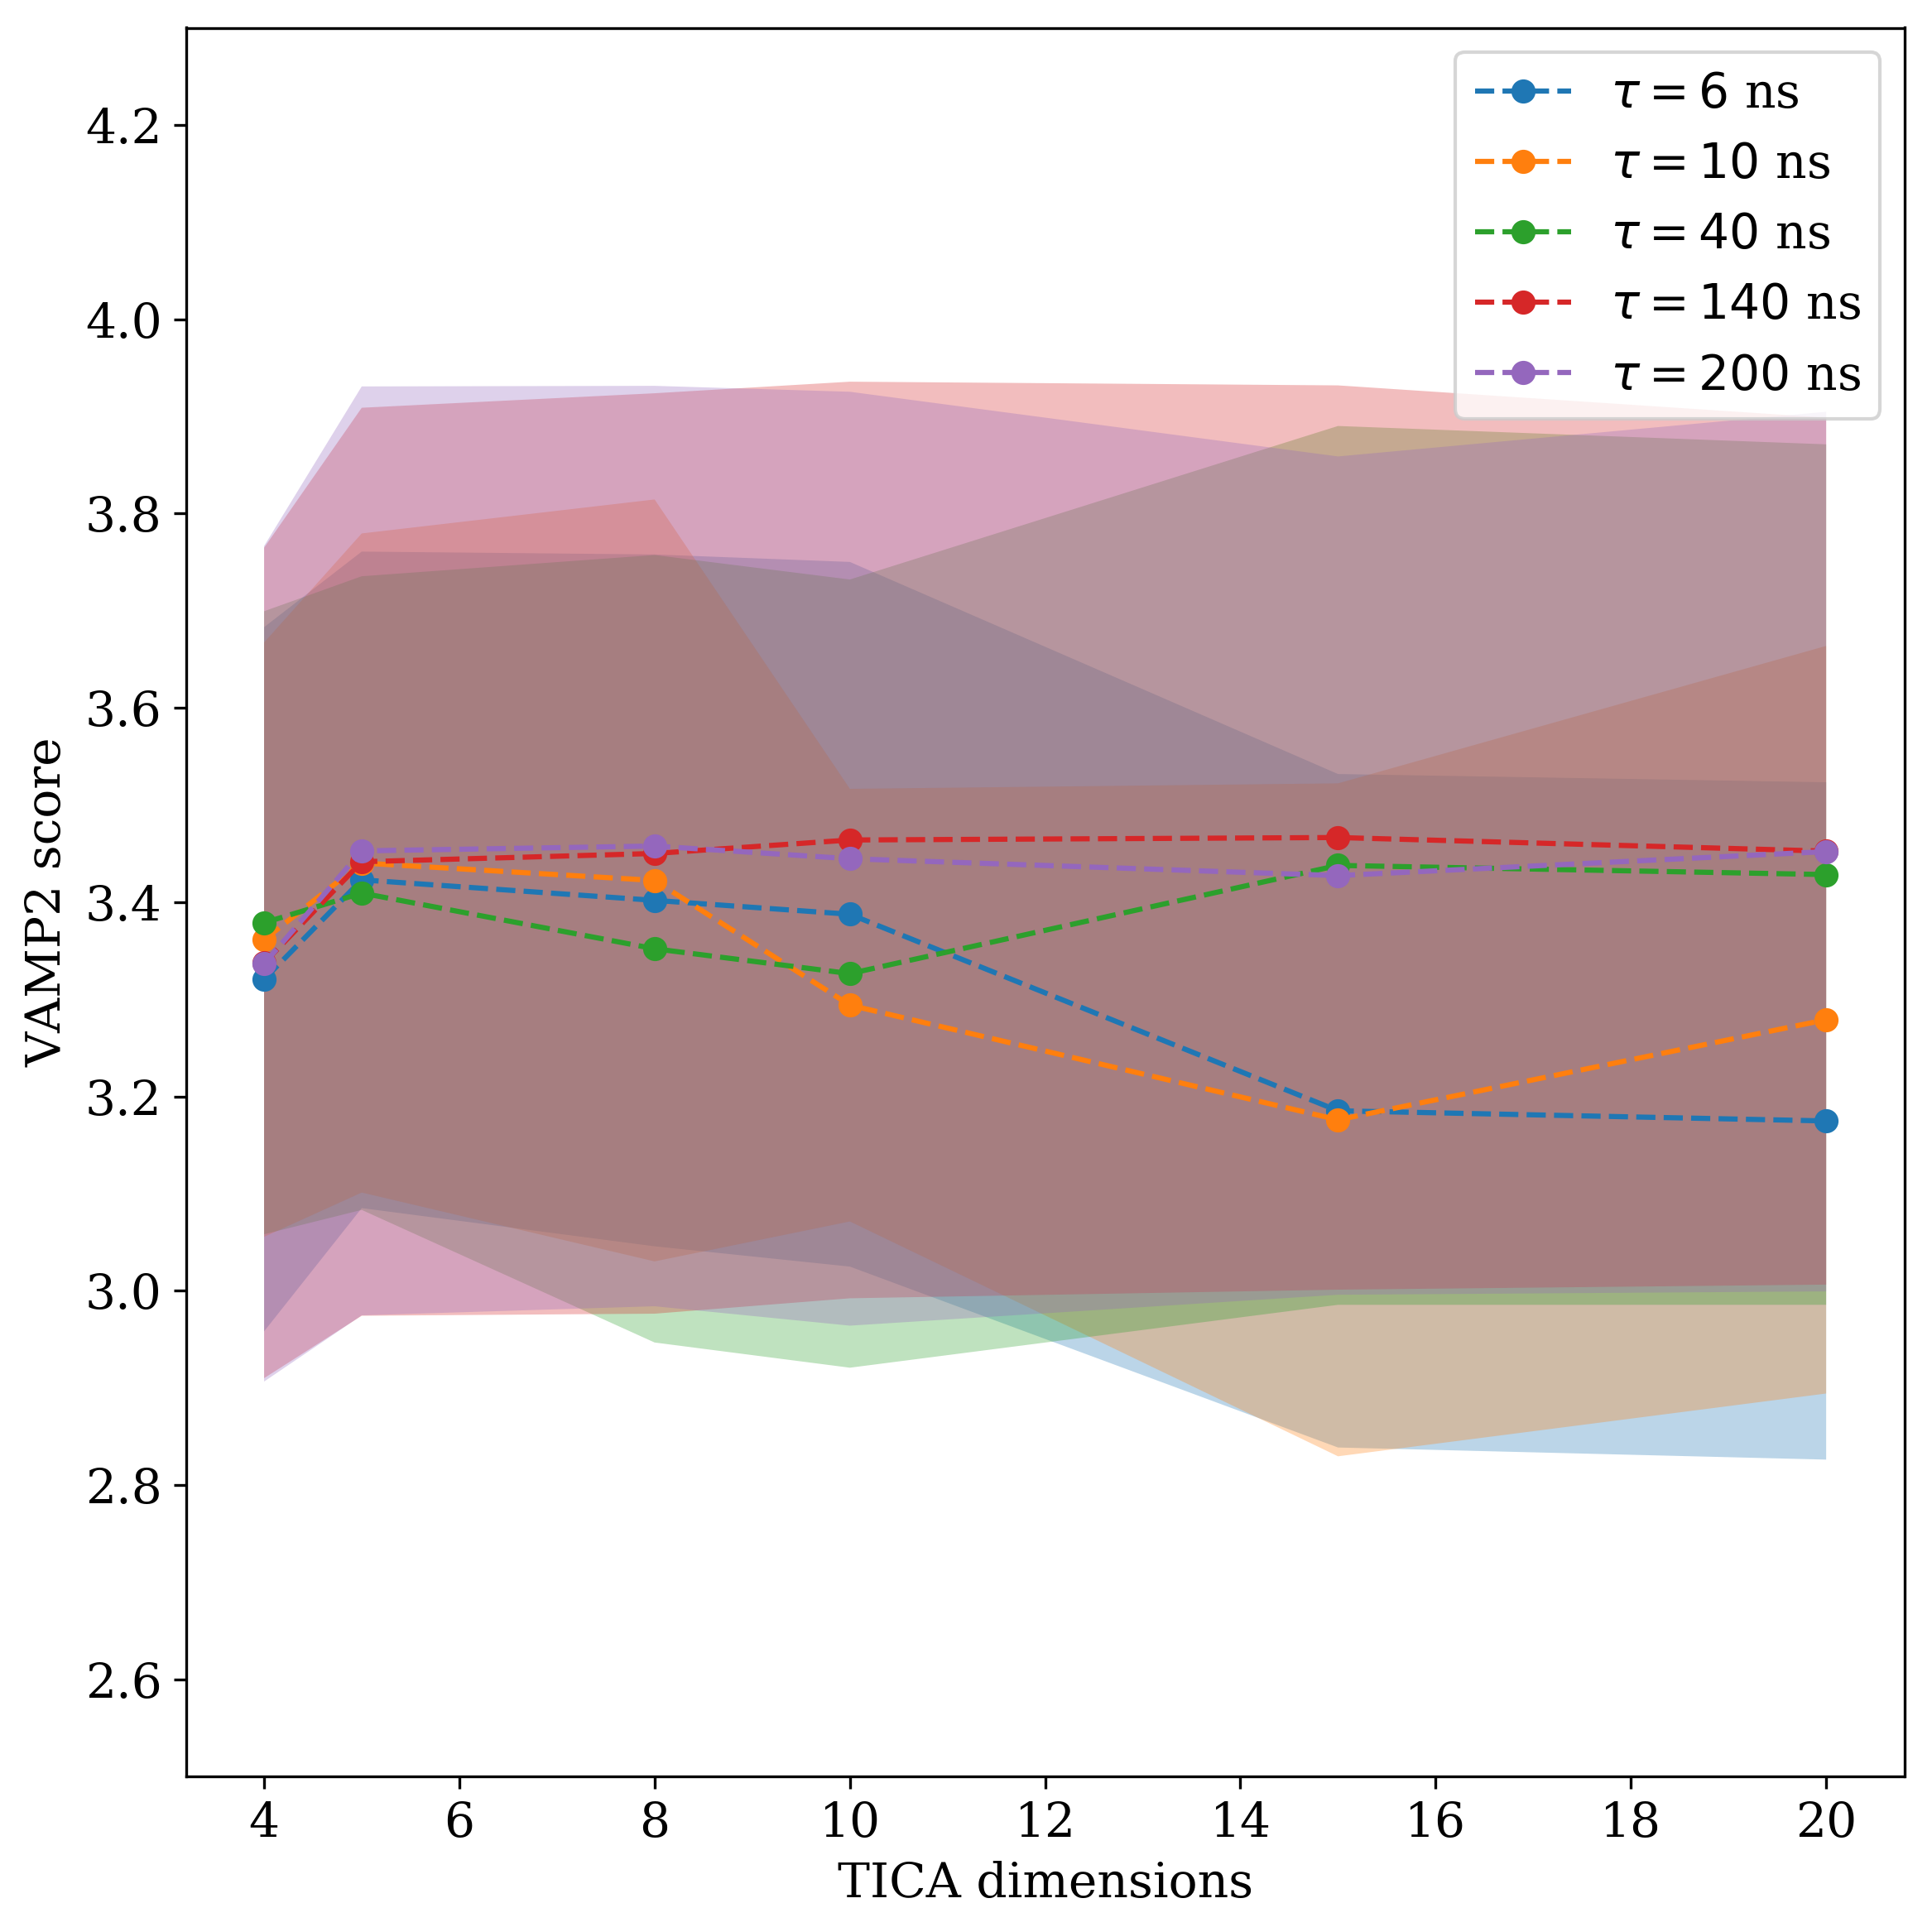

In [40]:
fig, ax = plt.subplots(figsize=(8, 8), dpi=300)
for i, lag in enumerate(tica_lags):
    color = "C{}".format(i)
    ax.fill_between(tica_dims, scores_avg[i,:] - scores_err[i,:], scores_avg[i,:] + scores_err[i,:], alpha=0.3, facecolor=color)
    ax.plot(tica_dims, scores_avg[i,:], "--o", color=color, label=r"$\tau = {:.0f}$ ns".format(lag * 0.2))

ax.legend()
ax.set_xlabel("TICA dimensions")
ax.set_ylabel("VAMP2 score")
ax.set_ylim([2.5,4.3])
fig.tight_layout()
plt.savefig("tica_vamp_optim.png")
plt.show()

Although the confidence intervals overlap significantly for all lag times, there's a general downward trend as the number of TICA dimensions used to construct the MSM increases. This isn't too surprising given what we stated above. We also find that for increased lag times, a drop in model performance. Therefore, we will settle for a TICA lag-time of 6 ns (30 steps) and a dimension of 5. 

In [13]:
tica_dim = 5
tica_lag = 700

## TICA visualization

In [14]:
tica = pyemma.coordinates.tica(data=combined_data, lag=tica_lag, dim=tica_dim, kinetic_map=True)
tica_output = tica.get_output()
Y = np.concatenate(tica_output)

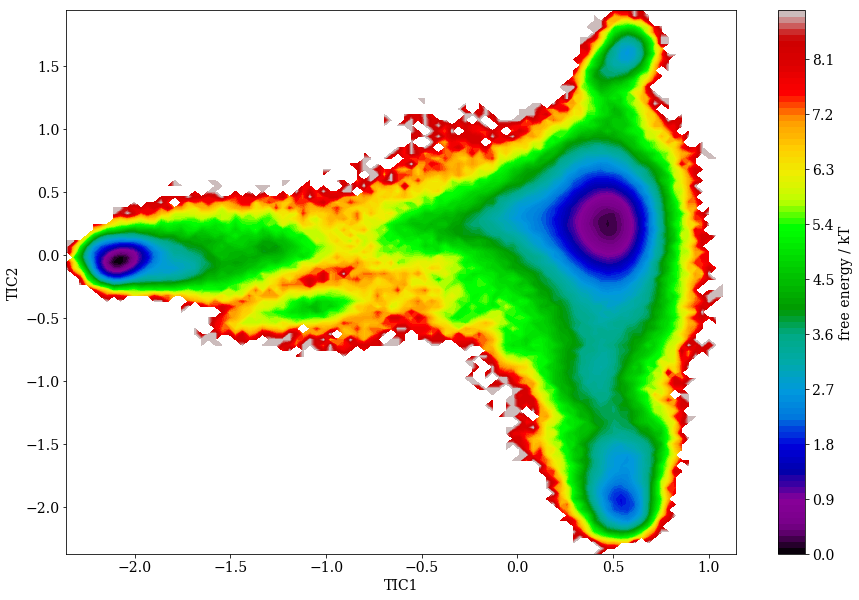

In [541]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111)
mplt.plot_free_energy(Y[:,0], Y[:,1], ax=ax)
plt.xlabel("TIC1")
plt.ylabel("TIC2")
#plt.savefig("tica_embed.png", dpi=600)
plt.show()

In [22]:
pairwise_tics = list(combinations(range(tica_dim), 2))

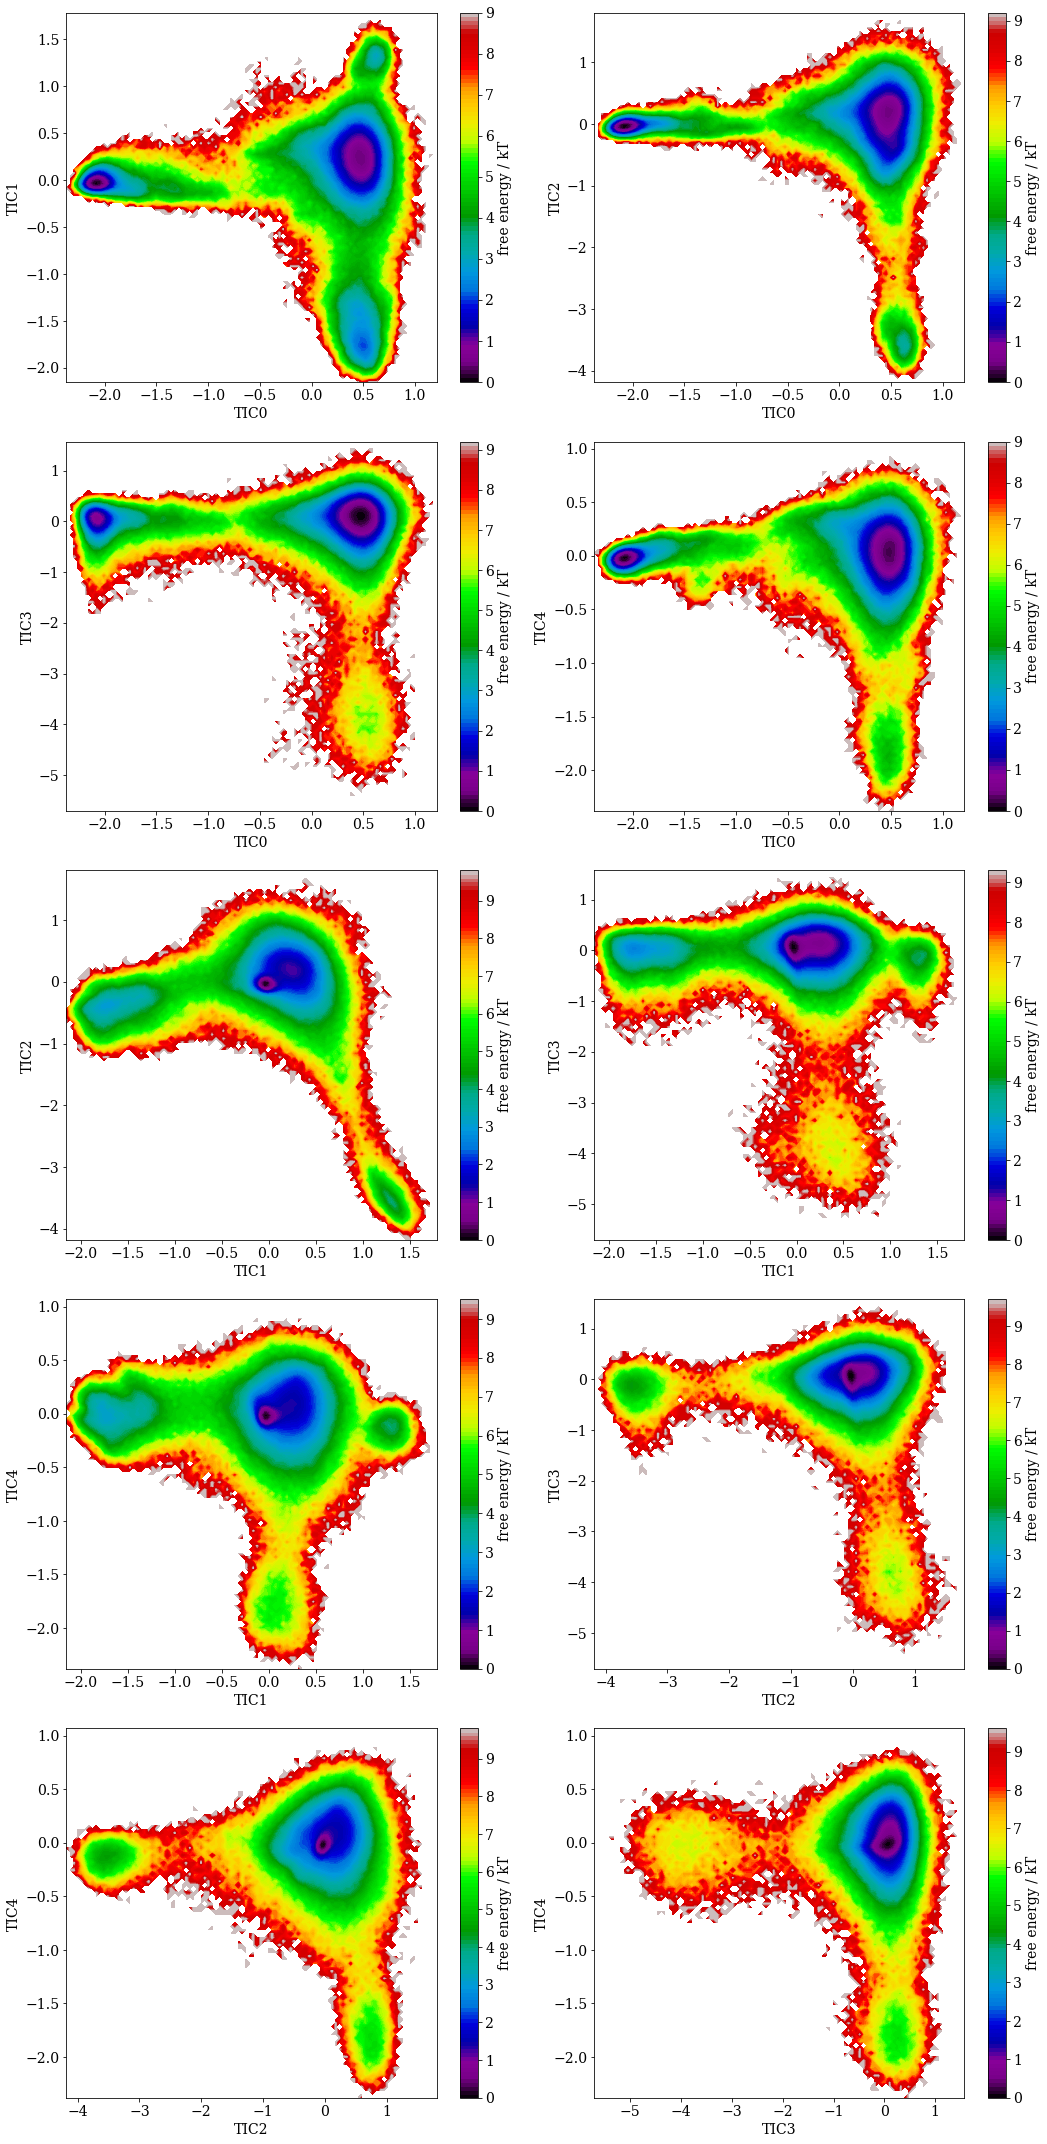

In [460]:
fig, axes = plt.subplots(5, 2, figsize=(15, 30))

for (i,j), ax in zip(pairwise_tics, axes.flat):
    mplt.plot_free_energy(Y[:,i], Y[:,j], ax=ax)
    ax.set_xlabel("TIC{}".format(i))
    ax.set_ylabel("TIC{}".format(j))

fig.tight_layout()
#plt.savefig("tica_projection.png", dpi=300)
plt.show()

Plot TICs vs time

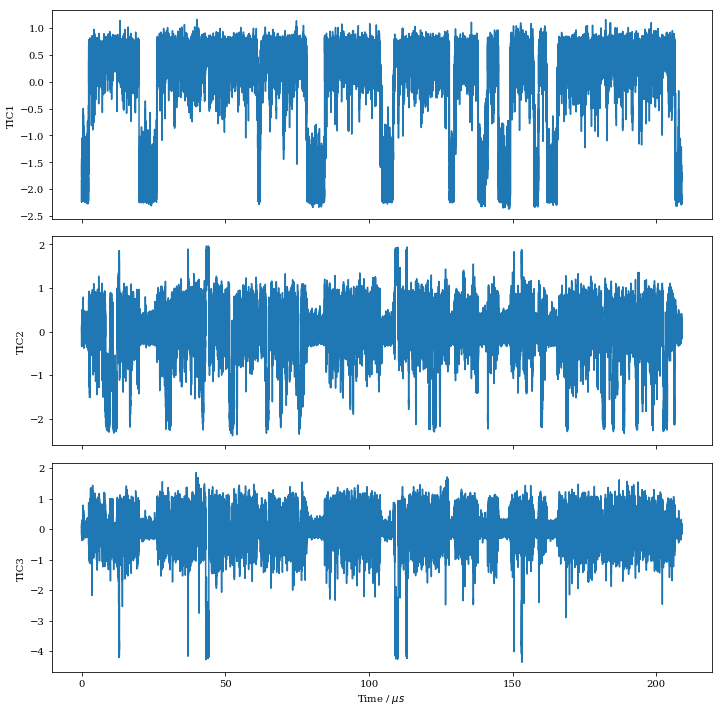

In [15]:
ts = np.array(range(Y.shape[0]))*2.0e-4
plt.figure(figsize=(10, 10))
plt.subplot2grid((3,1),(0,0))
plt.plot(ts, Y[:,0])
plt.ylabel('TIC1')
plt.gca().set_xticklabels([])
plt.subplot2grid((3,1),(1,0))
plt.plot(ts, Y[:,1])
plt.ylabel('TIC2')
plt.gca().set_xticklabels([])
plt.subplot2grid((3,1),(2,0))
plt.plot(ts, Y[:,2])
plt.ylabel('TIC3')
plt.xlabel(r"Time / $\mu s$")

plt.tight_layout()
#plt.savefig("tics_signal.png", dpi=300)
plt.show()

### Visualize against CVs

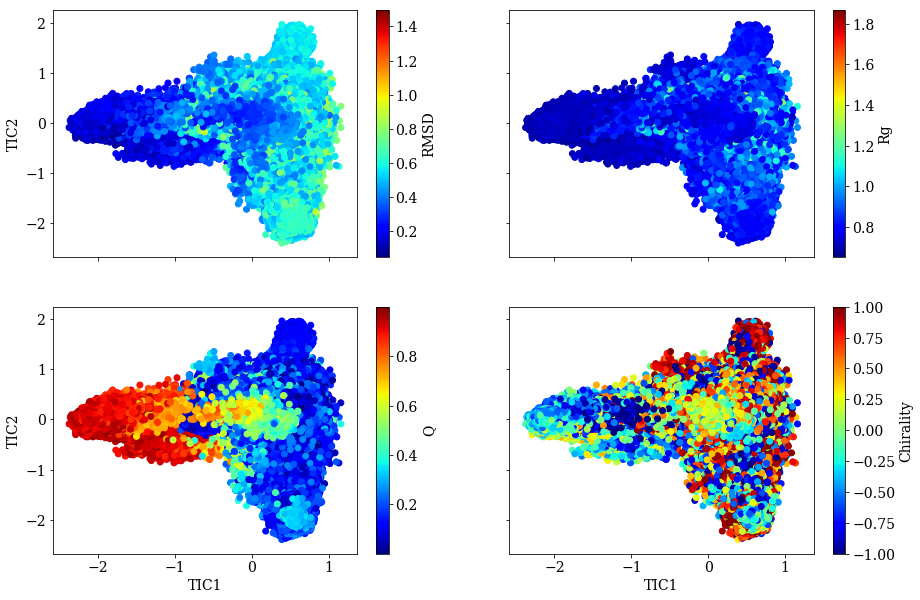

In [20]:
analysis.plot_projection_cvs(Y[:,0], Y[:,1], [rmsd_cv, rg_cv, q_cv, chiral_cv], ["RMSD", "Rg", "Q", "Chirality"], x_label="TIC1", y_label="TIC2")

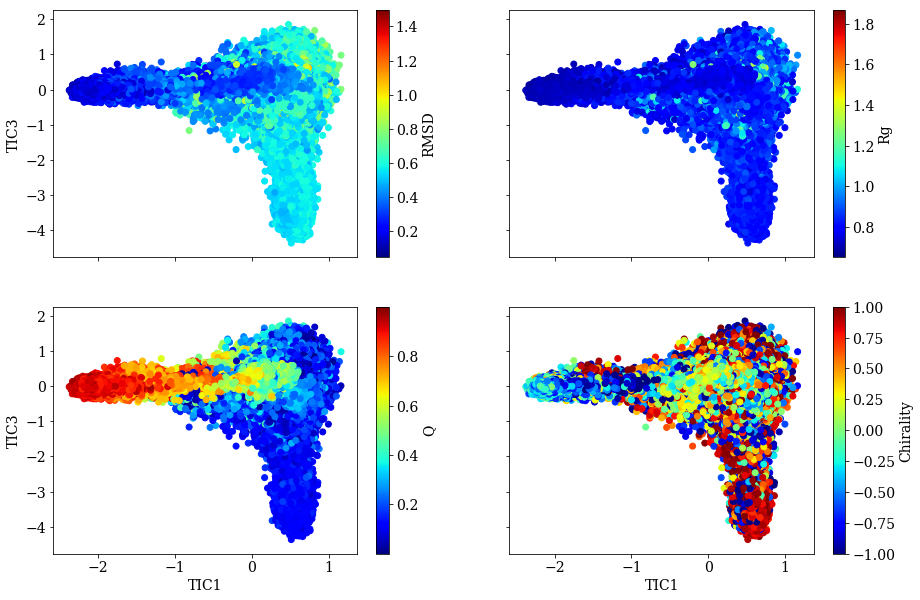

In [132]:
analysis.plot_projection_cvs(Y[:,0], Y[:,2], [rmsd_cv, rg_cv, q_cv, chiral_cv], ["RMSD", "Rg", "Q", "Chirality"], x_label="TIC1", y_label="TIC3")

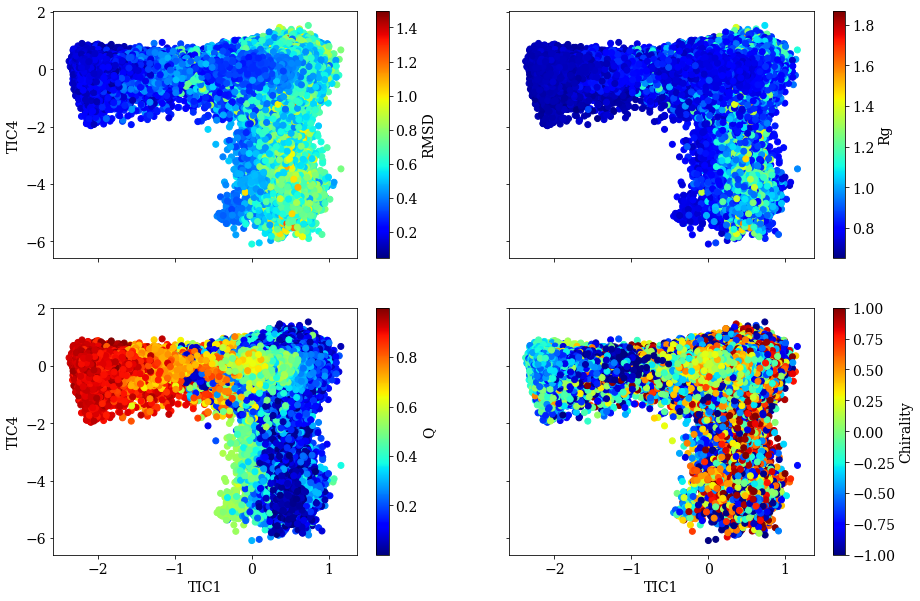

In [133]:
analysis.plot_projection_cvs(Y[:,0], Y[:,3], [rmsd_cv, rg_cv, q_cv, chiral_cv], ["RMSD", "Rg", "Q", "Chirality"], x_label="TIC1", y_label="TIC4")

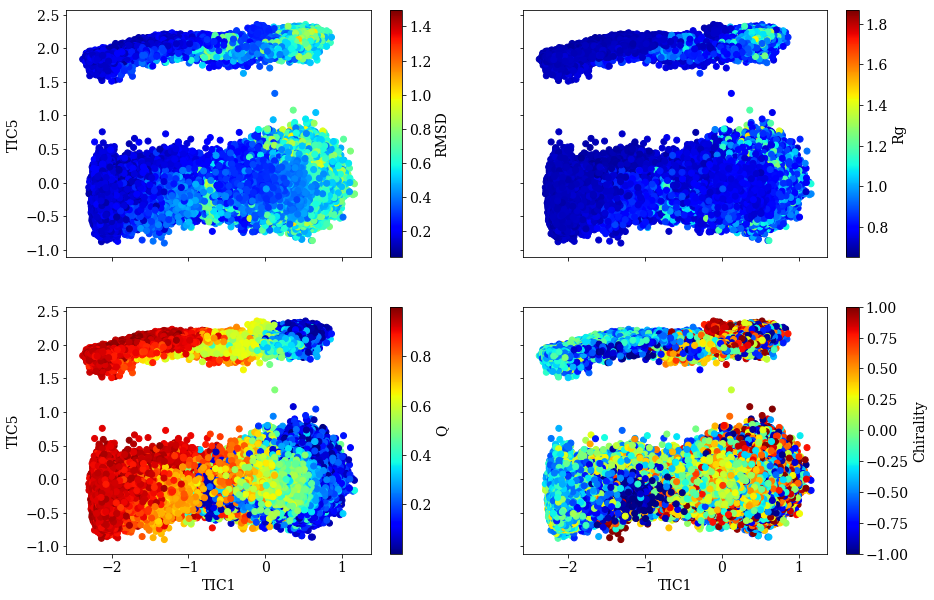

In [134]:
analysis.plot_projection_cvs(Y[:,0], Y[:,4], [rmsd_cv, rg_cv, q_cv, chiral_cv], ["RMSD", "Rg", "Q", "Chirality"], x_label="TIC1", y_label="TIC5")

### Clustering optimization

Now that we have optimized TICA, we fill focus on clustering. Above we used k=500 which was quite unnecessary. Let's optimize this now. 

In [81]:
n_clusters = [4, 5, 10, 20, 50, 100, 150, 200, 250]#, 300, 500]

In [82]:
cluster_scores_avg = np.zeros(len(n_clusters))
cluster_scores_err = np.zeros(len(n_clusters))

for i, k in enumerate(n_clusters):
    scores_ = score_cv_msm(combined_data, tica_dim, tica_lag, k, msm_lag=500)
    scores = np.mean(scores_)
    errors = np.std(scores_, ddof=1)
    
    # Store for later.
    cluster_scores_avg[i] = scores
    cluster_scores_err[i] = errors

10-09-18 13:29:37 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[610] WARNING  Requested scoring rank 8 exceeds number of MSM states. Reduced to score_k = 4
10-09-18 13:29:51 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[615] WARNING  Requested scoring rank 8 exceeds number of MSM states. Reduced to score_k = 4
10-09-18 13:30:06 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[620] WARNING  Requested scoring rank 8 exceeds number of MSM states. Reduced to score_k = 4
10-09-18 13:30:22 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[625] WARNING  Requested scoring rank 8 exceeds number of MSM states. Reduced to score_k = 4
10-09-18 13:30:36 pyemma.msm.estimators.maximum_likelihood_msm.MaximumLikelihoodMSM[630] WARNING  Requested scoring rank 8 exceeds number of MSM states. Reduced to score_k = 4
10-09-18 13:30:48 pyemma.coordinates.clustering.kmeans.KmeansClustering[634] WARNING  Algorithm did not reach convergenc

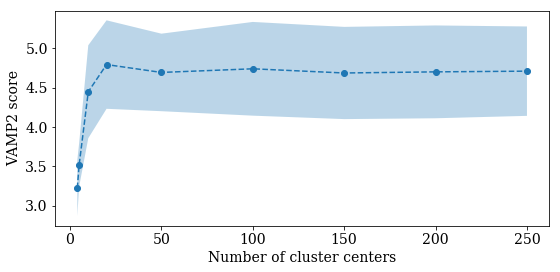

In [83]:
fig, ax = plt.subplots(figsize=(8, 4))

# Plot 
ax.fill_between(
    n_clusters, 
    cluster_scores_avg - cluster_scores_err, 
    cluster_scores_avg + cluster_scores_err, 
    alpha=0.3, facecolor="C0")

ax.plot(n_clusters, cluster_scores_avg, "--o", color="C0")

ax.set_xlabel("Number of cluster centers")
ax.set_ylabel("VAMP2 score")
fig.tight_layout()
#plt.savefig("ncenters_optim.png", dpi=300)
plt.show()

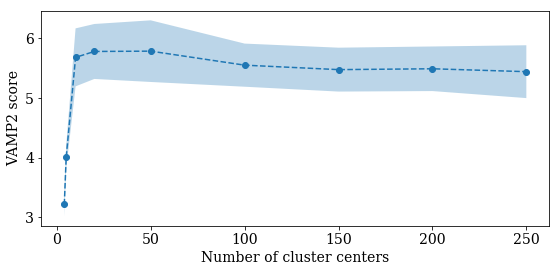

In [53]:
fig, ax = plt.subplots(figsize=(8, 4))

# Plot 
ax.fill_between(
    n_clusters, 
    cluster_scores_avg - cluster_scores_err, 
    cluster_scores_avg + cluster_scores_err, 
    alpha=0.3, facecolor="C0")

ax.plot(n_clusters, cluster_scores_avg, "--o", color="C0")

ax.set_xlabel("Number of cluster centers")
ax.set_ylabel("VAMP2 score")
fig.tight_layout()
plt.savefig("ncenters_optim.png", dpi=300)
plt.show()

Model performance is pretty stable after 50 centers. Let's go with 100. 

In [1]:
n_cluster = 100

In [18]:
cluster = pyemma.coordinates.cluster_kmeans(tica_output, k=n_cluster, max_iter=50, stride=1, n_jobs=1)

16-10-18 10:15:32 pyemma.coordinates.clustering.kmeans.KmeansClustering[9] WARNING  Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.


Visualize clusters on TICA projection

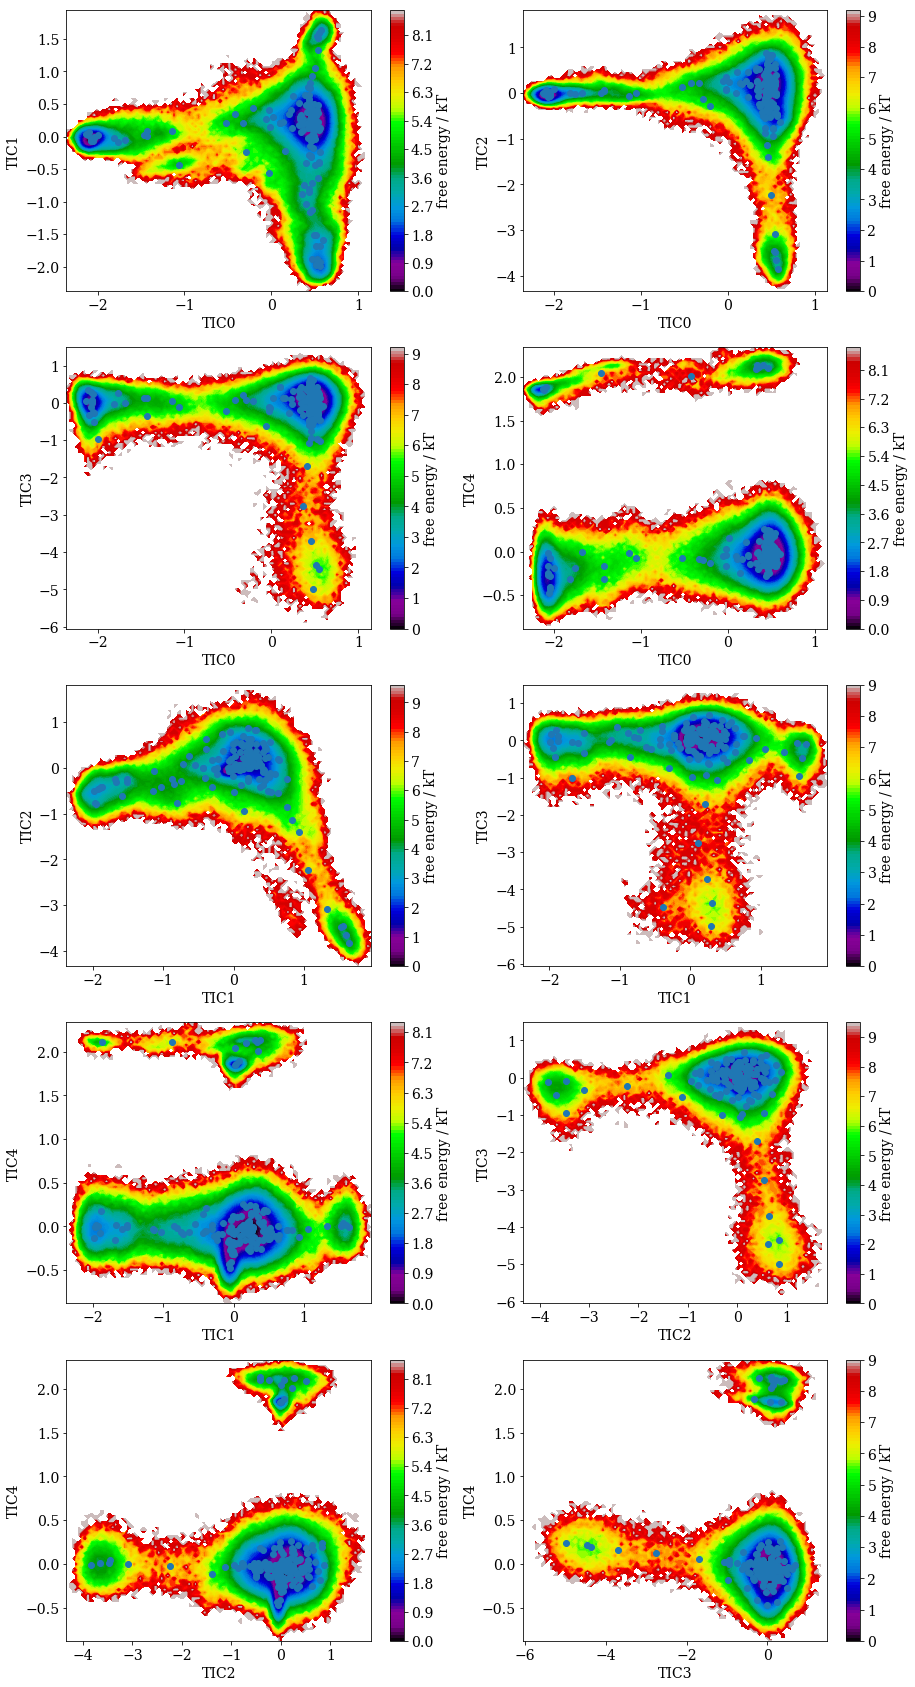

In [242]:
fig, axes = plt.subplots(5, 2, figsize=(15, 30))
#ax = fig.add_subplots(2, 5)
for (i,j), ax in zip(pairwise_tics, axes.flat):
    mplt.plot_free_energy(Y[:,i], Y[:,j], ax=ax)
    ax.scatter(cluster.cluster_centers_[:,i], cluster.cluster_centers_[:,j])
    ax.set_xlabel("TIC{}".format(i))
    ax.set_ylabel("TIC{}".format(j))

plt.show()

## Select MSM lag time 

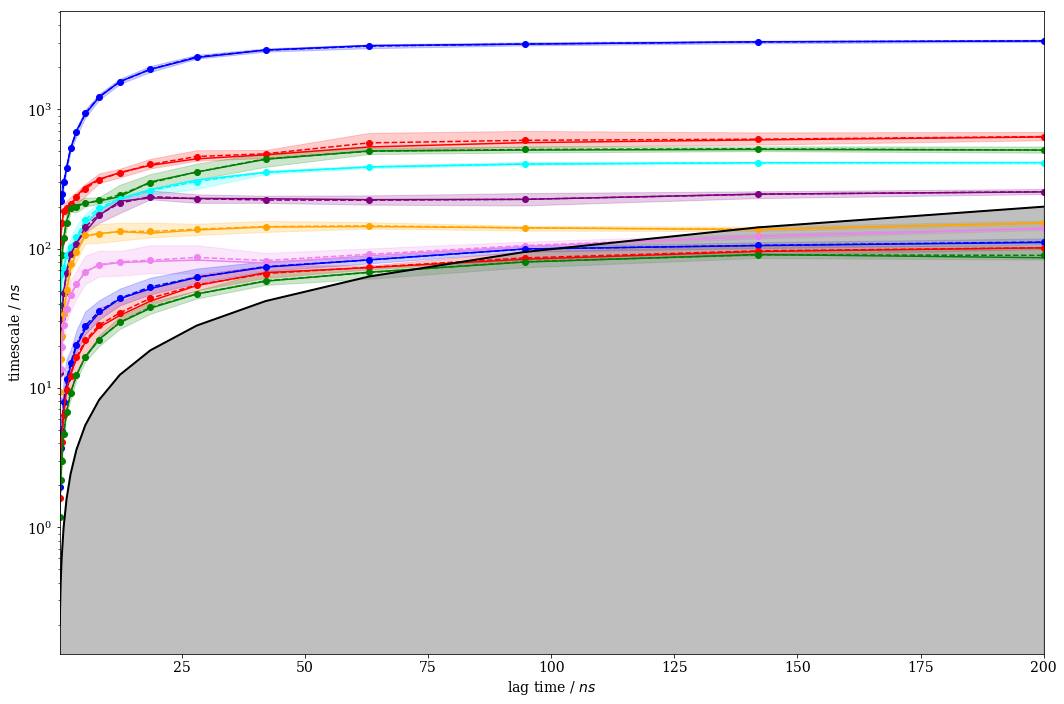

In [243]:
fig, ax = plt.subplots(figsize=(15, 10))
its = pyemma.msm.its(cluster.dtrajs, lags=1000, nits=10, errors="bayes")
pyemma.plots.plot_implied_timescales(its, dt=[0.2, 0.2], units=["$ns$", "$ns$"], ax=ax)
plt.tight_layout()
#plt.savefig("msm_its.png", dpi=300)
plt.show()

An MSM lag time of $\approx 35$ nanoseconds seems reasonable. Let's build it and visualize.

## Build MSM and validate

In [19]:
msm = pyemma.msm.bayesian_markov_model(cluster.dtrajs, lag=250, dt_traj="0.2 ns")
print("Fraction of states used = {:.2f}".format(msm.active_state_fraction))
print("Fraction of counts used = {:.2f}".format(msm.active_count_fraction))

Fraction of states used = 1.00
Fraction of counts used = 1.00


### Chapman-Kolmogorov test

This is one way of validating our model by propagating our transition matrix forward `mlag` steps, and comparing two independent measures via: 

$$
T(k \tau) = T^k(\tau)
$$

We test 5 states (slowest mode + 4 faster ones) and see that our predictions match the estimates very well, so we pass the test!

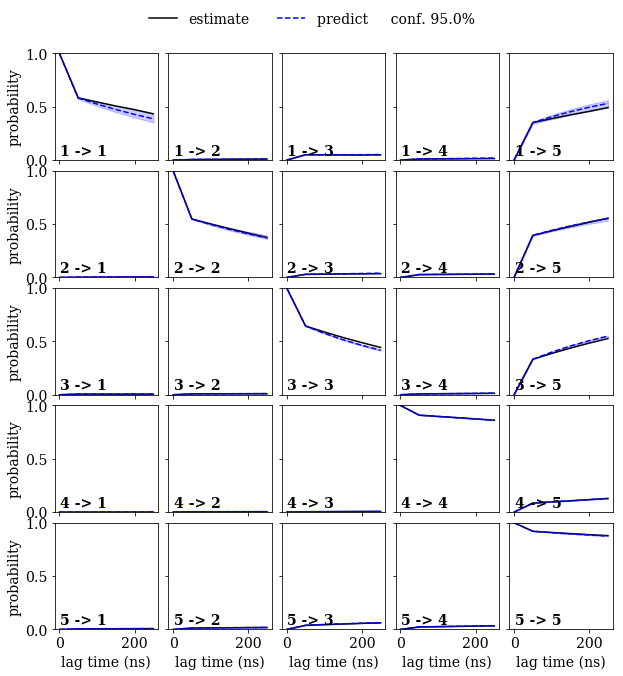

In [582]:
nstates = 5
cktest = msm.cktest(nstates, mlags=6)
mplt.plot_cktest(cktest, dt=0.2, units="ns")
plt.show()

Now we look at the implied timescales and associated uncertainty. It is clear that there is a single dominant coordinate (aka single dominant CV).

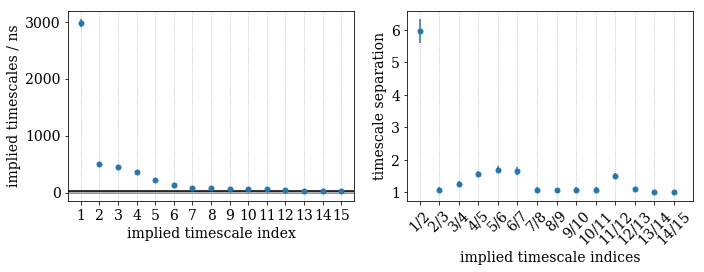

In [722]:
def its_separation_err(ts, ts_err):
    """
    Error propagation from ITS standard deviation to timescale separation.
    """
    return ts[:-1] / ts[1:] * np.sqrt(
        (ts_err[:-1] / ts[:-1])**2 + (ts_err[1:] / ts[1:])**2)


nits = 15

timescales_mean = msm.sample_mean('timescales', k=nits)
timescales_std = msm.sample_std('timescales', k=nits)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].errorbar(
    range(1, nits + 1),
    timescales_mean, 
    yerr=timescales_std, 
    fmt='.', markersize=10)
axes[1].errorbar(
    range(1, nits),
    timescales_mean[:-1] / timescales_mean[1:], 
    yerr=its_separation_err(
        timescales_mean, 
        timescales_std), 
    fmt='.', 
    markersize=10,
    color='C0')

for i, ax in enumerate(axes):
    ax.set_xticks(range(1, nits + 1))
    ax.grid(True, axis='x', linestyle=':')
    
axes[0].axhline(msm.lag * 0.1, lw=1.5, color='k')
axes[0].axhspan(0, msm.lag * 0.1, alpha=0.3, color='k')
axes[0].set_xlabel('implied timescale index')
axes[0].set_ylabel('implied timescales / ns')
axes[1].set_xticks(range(1, nits))
axes[1].set_xticklabels(
    ["{:d}/{:d}".format(k, k + 1) for k in range(1, nits + 2)],
    rotation=45)
axes[1].set_xlabel('implied timescale indices')
axes[1].set_ylabel('timescale separation')
fig.tight_layout()

## Visualize MSM Eigenfunctions

In [20]:
tica_output = tica.get_output()
Y = np.concatenate(tica_output)
dtrajs_concatenated = np.concatenate(cluster.dtrajs)

In [ ]:
viz_dims = [
    (0, 1),
    (2, 3),
    (1, 3),
    (1, 4),
    (0, 4),
    (0, 4),
    (1, 4),
    (0, 1),
    (1, 4),
    (1, 4)
]

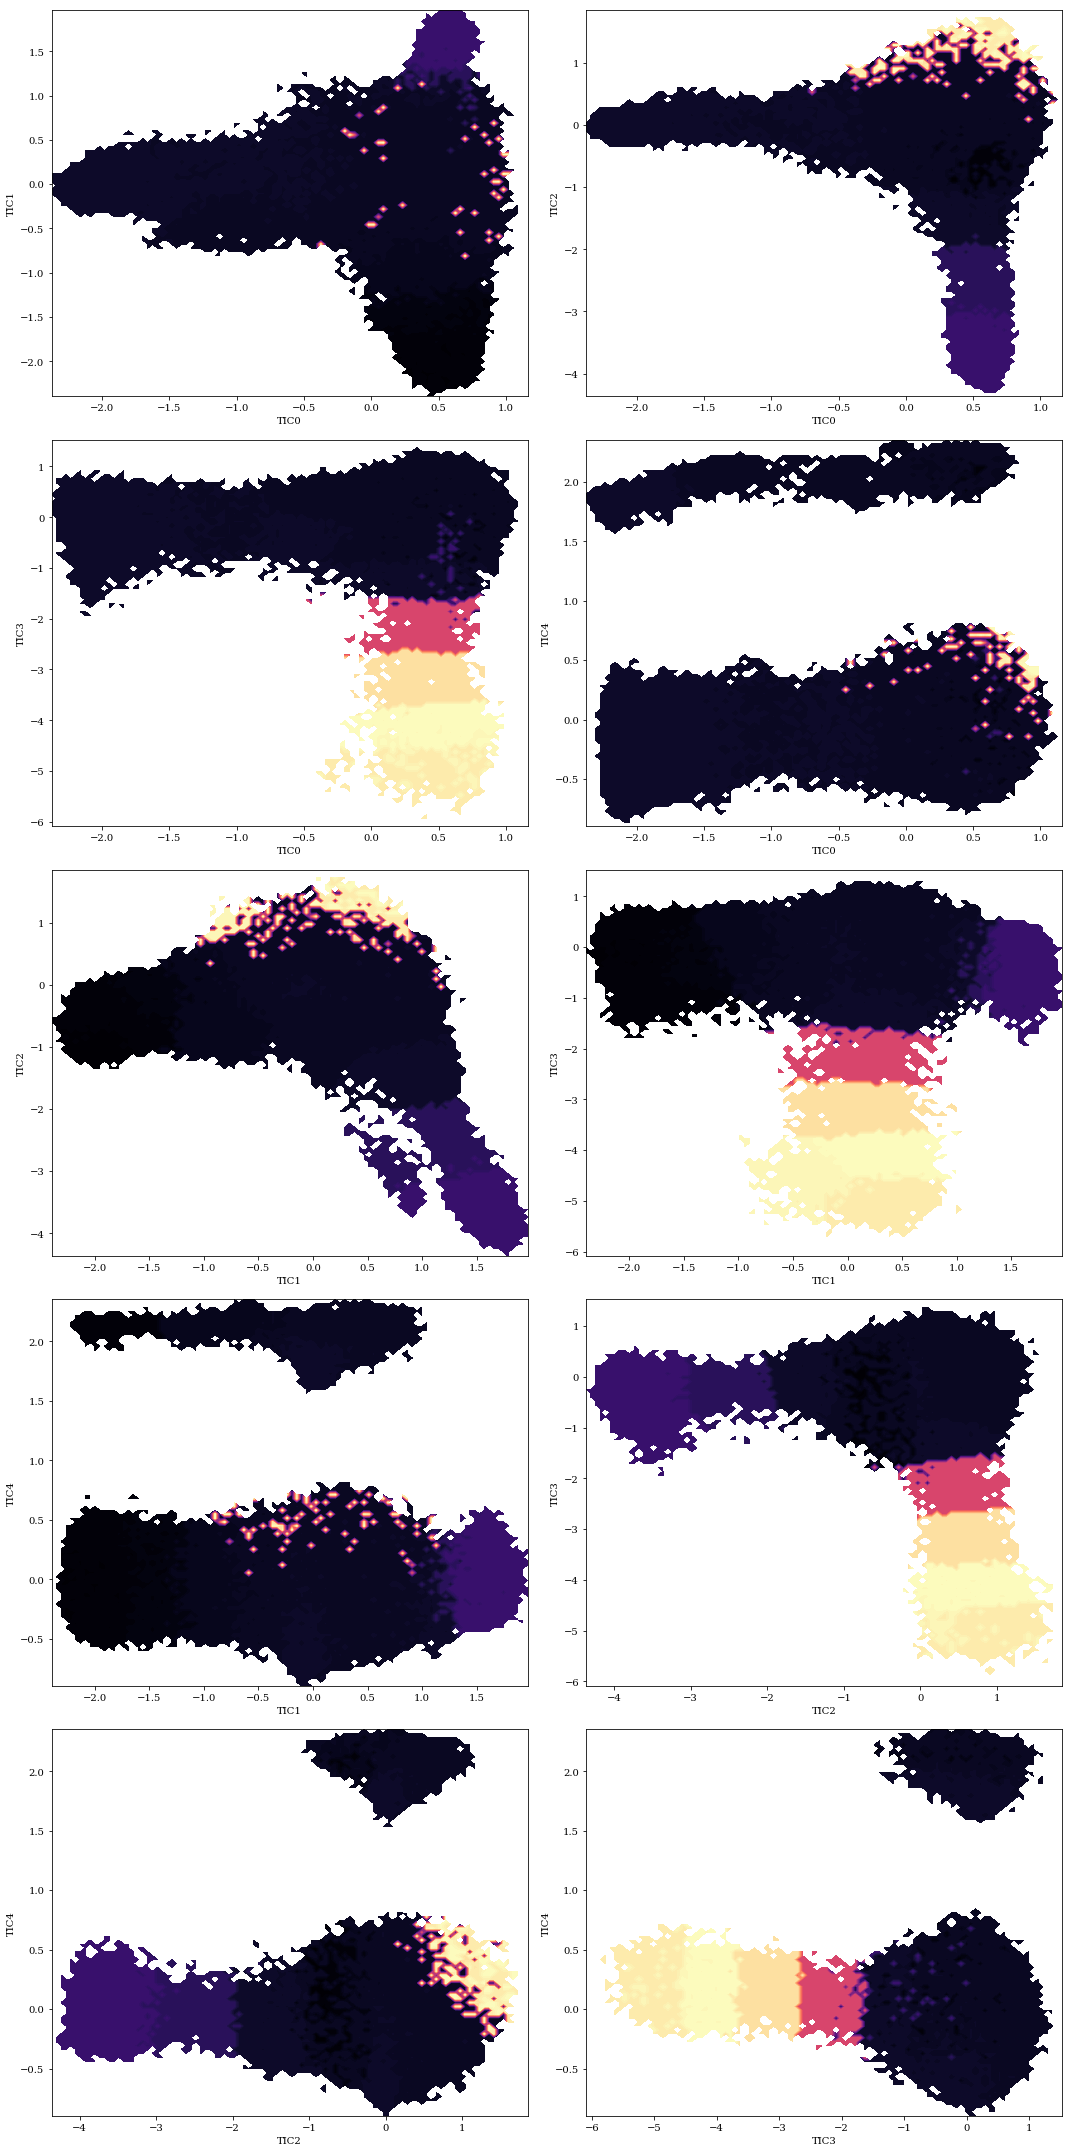

In [25]:
eig_num = 3
eigvec = msm.eigenvectors_right()

fig, axes = plt.subplots(5, 2, figsize=(15, 30))
for (i,j), ax in zip(pairwise_tics, axes.flat):
    pyemma.plots.plot_contour(
        *Y[:, [i, j]].T,
        eigvec[dtrajs_concatenated, eig_num],
        ax=ax,
        cmap="magma",
        cbar=False,
        cbar_label="$\Psi_{}$".format(np.mod(i,5) + 2),
        mask=True)
    ax.set_xlabel("TIC{}".format(i))
    ax.set_ylabel("TIC{}".format(j))

fig.tight_layout()
#plt.savefig("eigenfunctions.png", dpi=300)
plt.show()

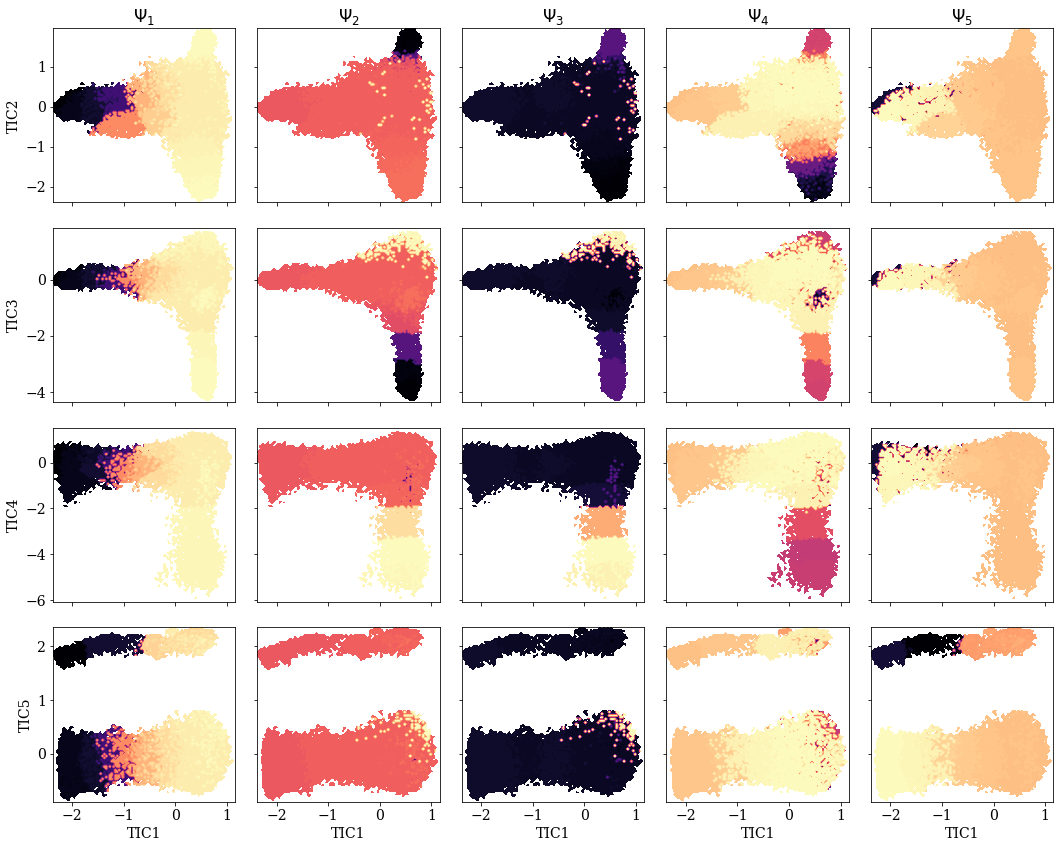

In [578]:
eigvec = msm.eigenvectors_right()

fig, axes = plt.subplots(4, 5, figsize=(15, 12), sharex=True, sharey="row")
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *Y[:, [0,i//5+1]].T,
        eigvec[dtrajs_concatenated, np.mod(i,5) + 1],
        ax=ax,
        cmap="magma",
        cbar=False,
        cbar_label="$\Psi_{}$".format(np.mod(i,5) + 2),
        mask=True)
    if np.mod(i,5) == 0:
        ax.set_ylabel("TIC{}".format(i//5+2))
    if i//5 == 3:
        ax.set_xlabel("TIC1")
    if i < 5:
        ax.set_title(r"$\Psi_{}$".format(i+1))

fig.tight_layout()
#plt.savefig("eigenfunctions.png", dpi=300)
plt.show()

## Visualize reweighted TICA projections

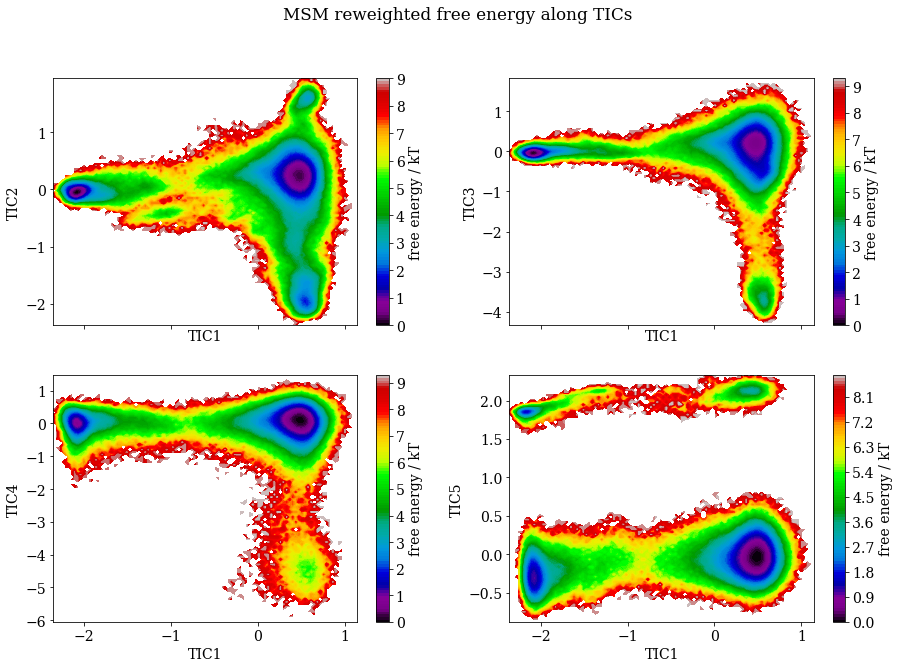

In [31]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=True)
for i, ax in enumerate(axes.flat):
    mplt.plot_free_energy(
    *Y[:, [0,i+1]].T,
    weights=np.concatenate(msm.trajectory_weights()),
    ax=ax
    )
    ax.axis("tight")
    ax.set_xlabel("TIC1")
    ax.set_ylabel("TIC{}".format(i+2))
    
plt.suptitle("MSM reweighted free energy along TICs")
plt.show()

## Coarse-grain and visualize states

In [775]:
nstates = 6
pcca = msm.pcca(nstates)

In [776]:
metastable_traj = msm.metastable_assignments[dtrajs_concatenated]

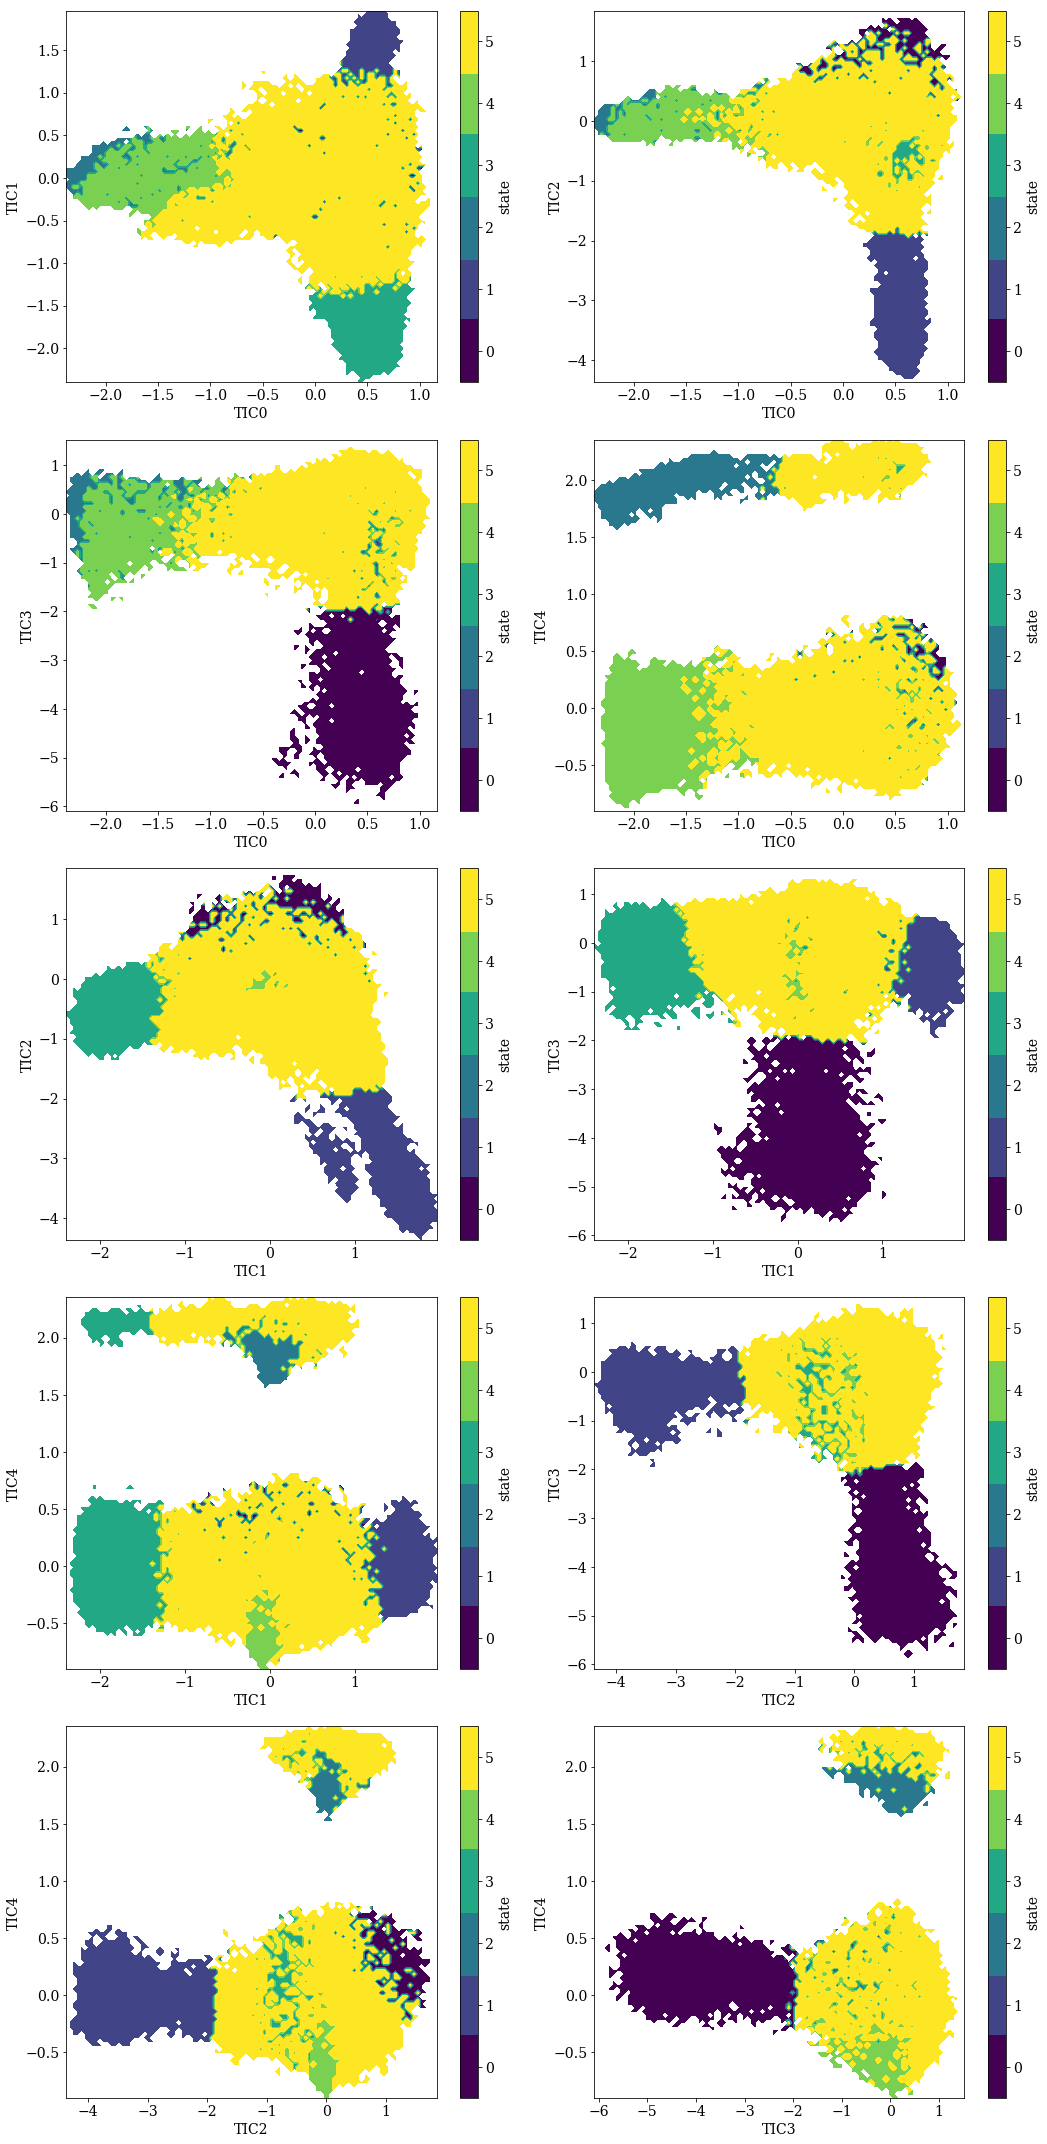

In [777]:
fig, axes = plt.subplots(5, 2, figsize=(15, 30))
    
for (i,j), ax in zip(pairwise_tics, axes.flat):
    _, _, misc = pyemma.plots.plot_state_map(*Y[:, [i,j]].T, metastable_traj, ax=ax)
    #misc["cbar"].set_ticklabels(range(1, nstates+1))
    ax.set_xlabel("TIC{}".format(i))
    ax.set_ylabel("TIC{}".format(j))

fig.tight_layout()
#plt.savefig("pcca_states.png", dpi=300)
plt.show()

### Save model 

In [100]:
msm.save("trp-cage_optim_msm.h5")

In [ ]:
msm = pyemma.load("trp-cage_optim_msm.h5")

In [785]:
%load_ext autoreload 
%autoreload 2

## Analyize distributions of each state

In [653]:
state_rmsd = md.rmsd(trj_ca_slice, trj_ca_slice, frame=0)

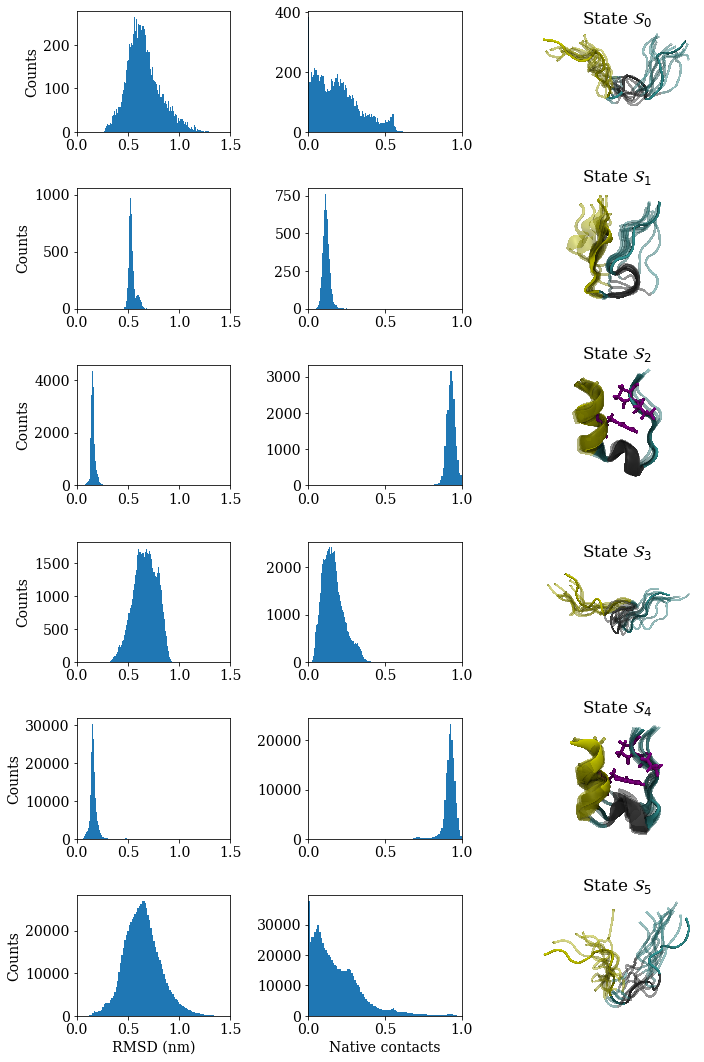

In [804]:
fig, axes = plt.subplots(nstates, 3, figsize=(10, 15))

for (state, ax1, ax2, ax3) in zip(np.sort(np.unique(msm.metastable_assignments)), *[iter(axes.flat)]*3):
    ax1.hist(state_rmsd[metastable_traj == state], bins=100)
    ax1.set_xlim([0, 1.5])
    ax1.set_ylabel('Counts')
    ax2.hist(q_cv[metastable_traj == state], bins=100)
    ax2.set_xlim([0, 1.0])
    ax3.set_axis_off()
    ax3.imshow(plt.imread("data/pcca{}.bmp".format(state+1)))
    ax3.set_title(r"State $\mathcal{{S}}_{}$".format(state))
    
axes[-1, 0].set_xlabel('RMSD (nm)')
axes[-1, 1].set_xlabel('Native contacts')
plt.tight_layout()
plt.savefig('rmsd_q_img_panel.png', dpi=300)
plt.show()

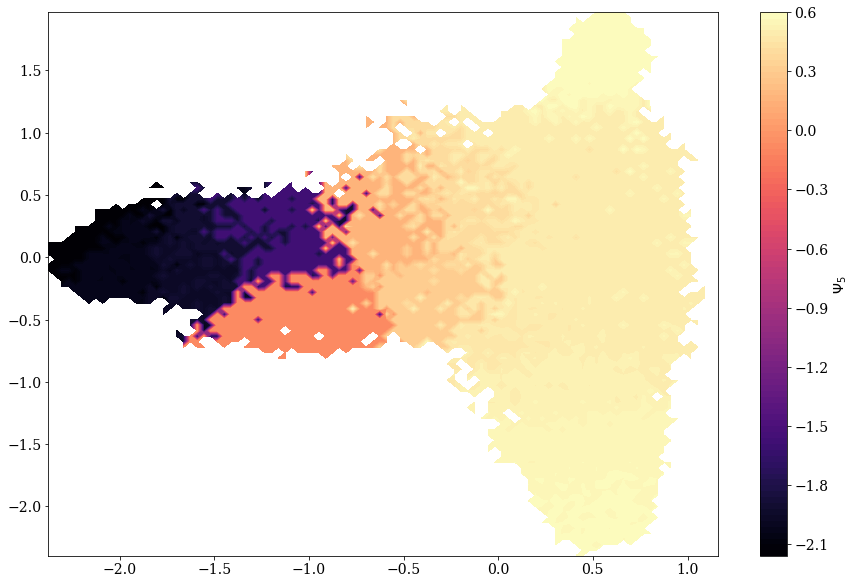

In [668]:
fig, ax = plt.subplots(1,1, figsize=(15, 10))
_, _, misc = pyemma.plots.plot_contour(
    *Y[:, [0, 1]].T,
    eigvec[dtrajs_concatenated,1],
    ax=ax,
    cmap="magma",
    cbar=True,
    cbar_label="$\Psi_{}$".format(np.mod(i,5) + 2),
    mask=True)

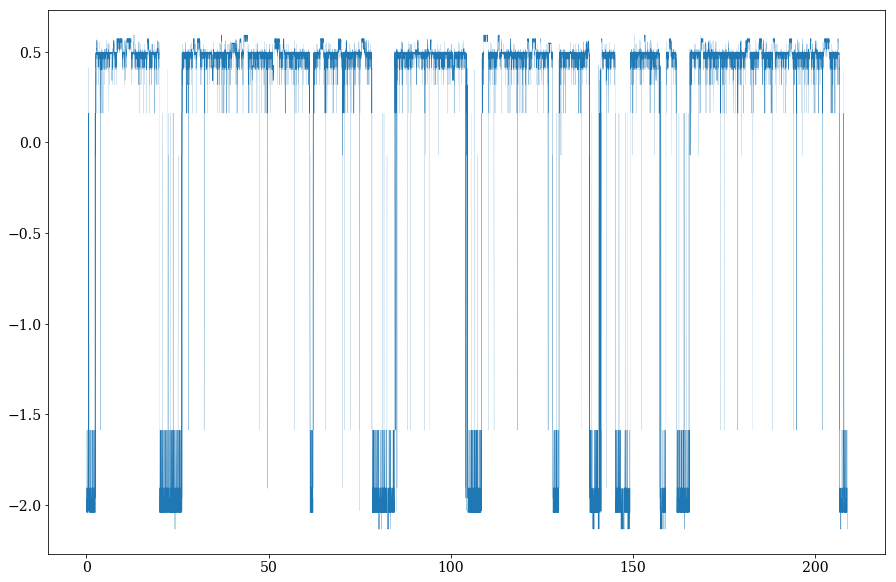

In [808]:
plt.figure(figsize=(15, 10))
plt.plot(ts, sm1, linewidth=0.1)

In [840]:
((sm1[:-1] > -1) & (sm1[1:] < -2)).sum()

20

In [752]:
eigvec = msm.eigenvectors_right()
sm1 = eigvec[dtrajs_concatenated, 1]

In [710]:
index = np.array(range(len(metastable_traj)))

In [730]:
index[metastable_traj == 0][2712]

201638

## Analyze distribution of state 3 from above

In [158]:
# Compute RSMD between q_ref (native reference state) and state 7
state_rmsd = md.rmsd(trj, q_ref)

In [738]:
q_cv[201638-100:201638+100]

array([0.5535654 , 0.5458287 , 0.5463933 , 0.5374065 , 0.5266866 ,
       0.5488875 , 0.5511527 , 0.5495064 , 0.53474146, 0.53148025,
       0.54564565, 0.5536555 , 0.560386  , 0.53713864, 0.5468484 ,
       0.53752756, 0.54820544, 0.5309678 , 0.52189577, 0.53022194,
       0.5125807 , 0.52722657, 0.56490207, 0.6163478 , 0.40904143,
       0.56814134, 0.5704397 , 0.58552265, 0.5891603 , 0.58697987,
       0.54260147, 0.5043312 , 0.47144434, 0.54682183, 0.54858315,
       0.54407376, 0.5541857 , 0.54894906, 0.54852927, 0.55275387,
       0.54225993, 0.5522602 , 0.5484548 , 0.5505546 , 0.5611498 ,
       0.54790854, 0.5573462 , 0.55805016, 0.48182836, 0.55232483,
       0.54857683, 0.55076414, 0.54649675, 0.5480388 , 0.54978174,
       0.5482239 , 0.5422027 , 0.54572976, 0.5455979 , 0.5413853 ,
       0.524791  , 0.55031985, 0.5381591 , 0.5393041 , 0.5506598 ,
       0.53874695, 0.537411  , 0.5441551 , 0.5422068 , 0.53587615,
       0.5393586 , 0.5309107 , 0.5410637 , 0.5405045 , 0.53615

In [774]:
view = nv.show_mdtraj(trj[metastable_traj == 2])
view.add_trajectory(q_ref)
view

NGLWidget(count=3897)

In [733]:
view.frame = 201638

In [321]:
np.argwhere((metastable_traj == 0) & (rmsd_cv < 0.30))

array([[201857],
       [328531],
       [855187],
       [930380],
       [958684]])

In [331]:
rmsd_cv[(201857-200):(201857+100)]

array([0.346077  , 0.38198152, 0.3616253 , 0.3809271 , 0.4050662 ,
       0.3935205 , 0.40946847, 0.37460104, 0.35724962, 0.3955928 ,
       0.38056317, 0.38926962, 0.360391  , 0.36179802, 0.36119008,
       0.3920027 , 0.38967317, 0.4108553 , 0.40340307, 0.41196495,
       0.39972782, 0.37576902, 0.3965606 , 0.3941201 , 0.4039666 ,
       0.374868  , 0.3930741 , 0.3919639 , 0.3968164 , 0.3845678 ,
       0.36296648, 0.37256813, 0.38617164, 0.32063165, 0.37194303,
       0.41025227, 0.38288137, 0.43015656, 0.495939  , 0.4526886 ,
       0.46149817, 0.45660925, 0.45477563, 0.54030037, 0.5704975 ,
       0.58195907, 0.5469416 , 0.5689269 , 0.59822243, 0.5438789 ,
       0.5302805 , 0.59303117, 0.5263519 , 0.52305377, 0.53842014,
       0.54438424, 0.47307867, 0.49516562, 0.5339734 , 0.5308083 ,
       0.42643836, 0.5383882 , 0.4317251 , 0.42338327, 0.3996506 ,
       0.4304809 , 0.7691793 , 0.63661104, 0.71375763, 0.61856174,
       0.69228435, 0.66086966, 0.5809371 , 0.66679794, 0.56078

In [504]:
view = nv.show_mdtraj(trj[metastable_traj == 2])
#view.remove_cartoon()
#view.add_ball_and_stick()
#view.add_trajectory(q_ref)
#view[1].add_ball_and_stick()
view

NGLWidget(count=33257)

In [438]:
rmsd_cv_2 = md.rmsd(
            trj_ca_slice, 
            trj_ca_slice, 
            frame=0)

In [450]:
idxx = np.argwhere((rmsd_cv_2 < 0.2) & (ts > 27) & (ts < 40))

In [455]:
idxx

array([[162548],
       [162549],
       [162550],
       [162551]])

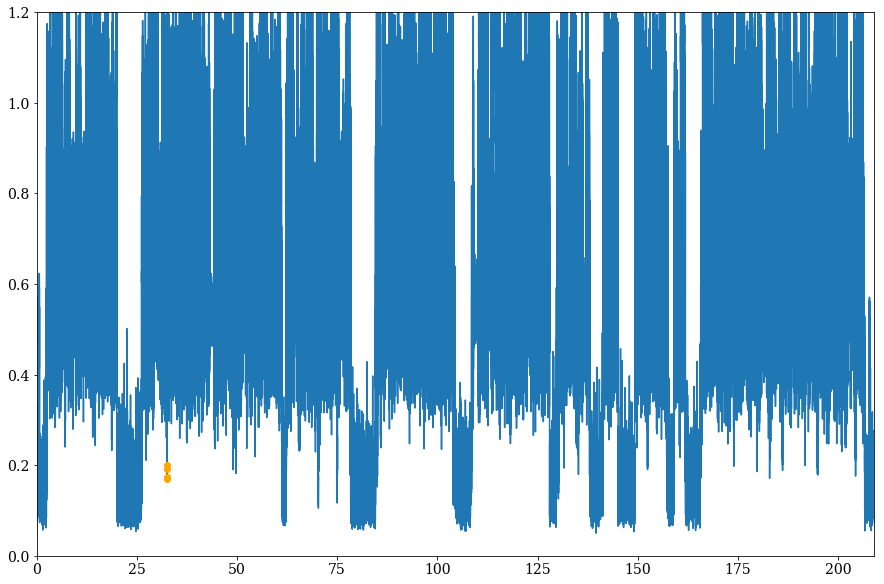

In [454]:
plt.figure(figsize=(15, 10))
plt.plot(ts, rmsd_cv_2)
#plt.plot(ts[(rmsd_cv < 0.2) & (ts > 132) & (ts < 137)], rmsd_cv[(rmsd_cv < 0.2) & (ts > 132) & (ts < 137)])
plt.scatter(ts[idxx], rmsd_cv_2[idxx], color="orange", zorder=10)
plt.xlim([0, ts.max()])
plt.ylim([0, 1.2])

plt.show()

In [647]:
T = pcca.coarse_grained_transition_matrix.copy()
T[T < 0] = 0
T = T/T.sum(axis=1)[:, np.newaxis]

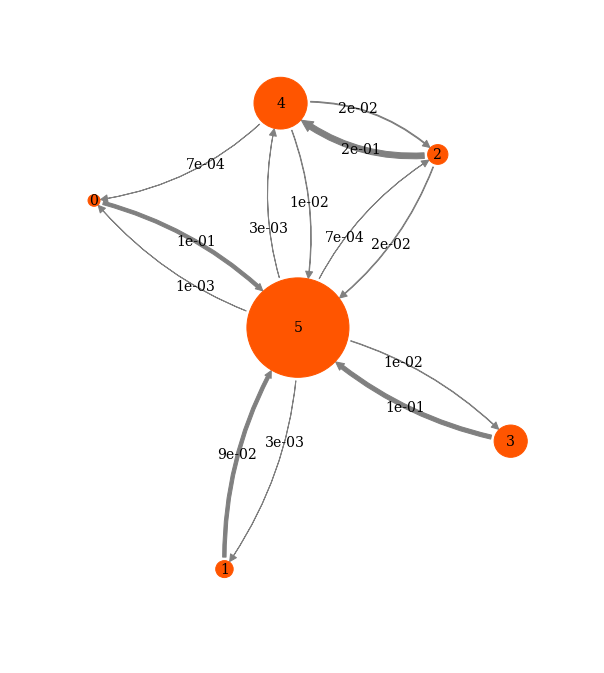

In [652]:
mplt.plot_markov_model(T, minflux=8e-5)
plt.show()

# Visualize trajectories with probabilities

In [441]:
pcca_samples = msm.sample_by_distributions(msm.metastable_distributions, 10)
combined_source = pyemma.coordinates.source(trj_file, features=combined_feat)
pyemma.coordinates.save_trajs(
    combined_source,
    pcca_samples,
    outfiles=["./data/pcca{}_10samples.pdb".format(n + 1)
              for n in range(msm.n_metastable)])

['./data/pcca1_10samples.pdb',
 './data/pcca2_10samples.pdb',
 './data/pcca3_10samples.pdb',
 './data/pcca4_10samples.pdb',
 './data/pcca5_10samples.pdb',
 './data/pcca6_10samples.pdb']

In [98]:
import matplotlib

/Users/hsidky/miniconda3/envs/dnets/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


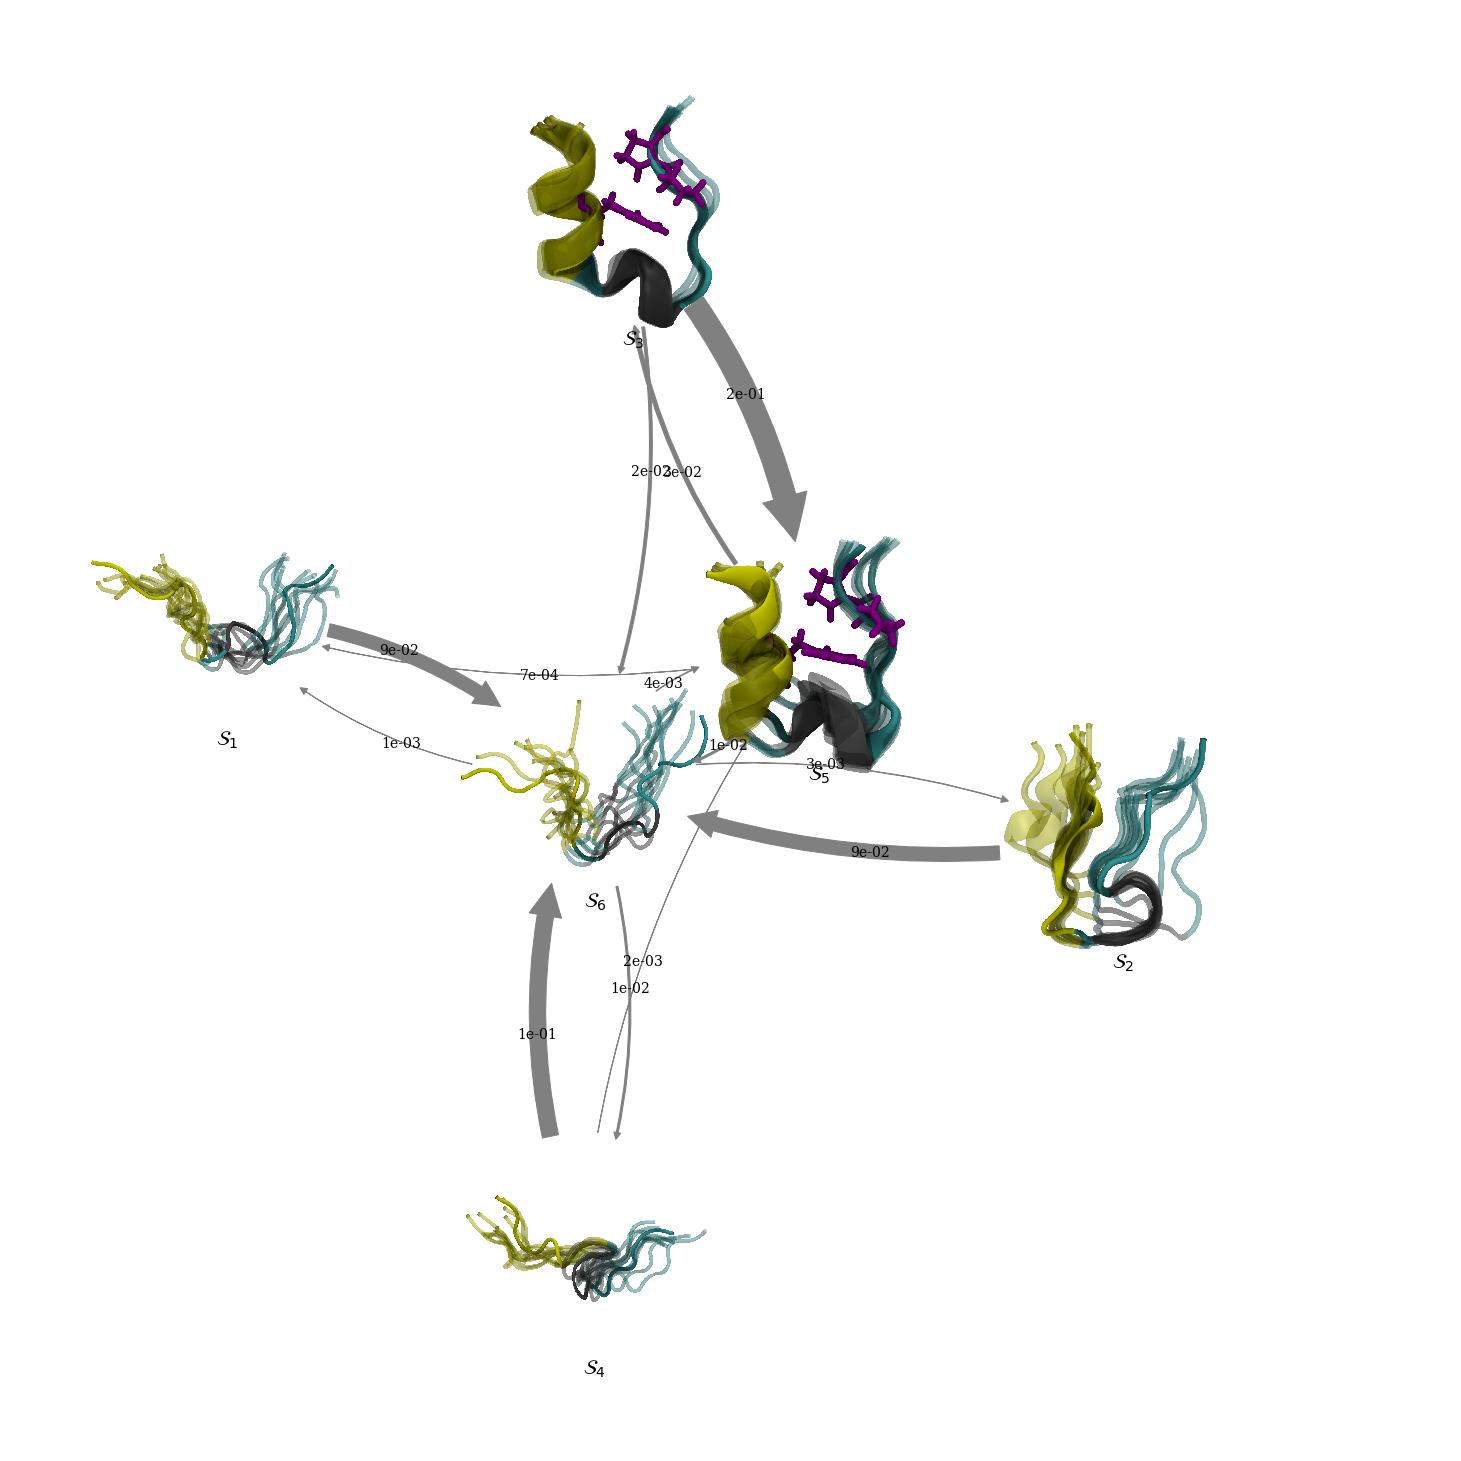

In [203]:
fig = plt.figure(figsize=(20, 20))
gw = int(np.floor(0.5 + 1000 * fig.get_figwidth()))
gh = int(np.floor(0.5 + 1000 * fig.get_figheight()))
gs = plt.GridSpec(gh, gw)
gs.update(hspace=0.0, wspace=0.0, left=0.0, right=1.0, bottom=0.0, top=1.0)
ax_box = fig.add_subplot(gs[:, :])

_, coor = mplt.plot_markov_model(
    T, 
    minflux=1e-4, 
    ax=ax_box, 
    state_sizes=np.array([200]*nstates), 
    arrow_scale=4, 
    state_colors="#ffffff",
    state_labels=None)

# Remove circles
for child in ax_box.get_children():
    if isinstance(child, matplotlib.patches.Circle):
        child.remove()

xl = ax_box.get_xlim()
yl = ax_box.get_ylim()
fsize = 0.18
for i, (x,y) in enumerate(coor):
    ax_ = fig.add_axes([(x-xl[0])/(xl[1]-xl[0])-fsize/2, (y-yl[0])/(yl[1]-yl[0])-fsize/2, fsize, fsize], zorder=-1)
    ax_.set_axis_off()
    ax_.imshow(plt.imread("data/pcca{}.bmp".format(i+1)), zorder=-1)
    ax_box.text(x, y-fsize*0.7, r"$\mathcal{{S}}_{}$".format(i+1), fontsize=20, weight="heavy")


fig.tight_layout()
plt.savefig("flux_viz.png", dpi=300)
plt.show()

## Visualize contact matrices in different states

In [124]:
from itertools import combinations

def contact_matrix(traj, d0, r0, n=6, m=12):
    heavy = traj.topology.select_atom_indices("heavy")
    # get the pairs of heavy atoms which are farther than 3
    # residues apart
    heavy_pairs = np.array(
        [(i,j) for (i,j) in combinations(heavy, 2)
            if abs(traj.topology.atom(i).residue.index - \
                   traj.topology.atom(j).residue.index) > 3])
    
    # compute the distances between these pairs in the native state
    r = md.compute_distances(traj, heavy_pairs)
    
    s = (1.0 - ((r - d0)/r0)**n)/(1.0 - ((r - d0)/r0)**m)
    return (s, heavy_pairs)

In [125]:
def distance_to_contact(dmat, d0, r0, n=6, m=12):  
    s = (1.0 - ((dmat - d0)/r0)**n)/(1.0 - ((dmat - d0)/r0)**m)
    return s

In [126]:
def get_state_atom_distmat(trj, states, label):
    idxs  = np.where(states == label)[0]
    samples = np.random.choice(idxs, replace=False, size=np.min([10, len(idxs)]))
    trj_slice = trj.slice(samples, copy=False)
    
    heavy = trj.topology.select_atom_indices("heavy")
    heavy_pairs = np.array(
        [(i,j) for (i,j) in combinations(heavy, 2)
            if abs(trj.topology.atom(i).residue.index - \
               trj.topology.atom(j).residue.index) > 3])

    r = md.compute_distances(trj, heavy_pairs)
    cmap = md.geometry.squareform(r, heavy_pairs)
    return cmap

In [127]:
def get_state_residue_distmat(trj, pairs, states, label):
    idxs  = np.where(states == label)[0]
    samples = np.random.choice(idxs, replace=False, size=np.min([10000, len(idxs)]))
    trj_slice = trj.slice(samples, copy=False)
    pair_dists, pair_ids = md.compute_contacts(trj_slice, all_pairs)
    cmap = md.geometry.squareform(pair_dists, pair_ids)
    return cmap

In [128]:
all_pairs = [(i,j) for (i,j) in combinations(range(0,20), 2)]

In [129]:
import seaborn as sns

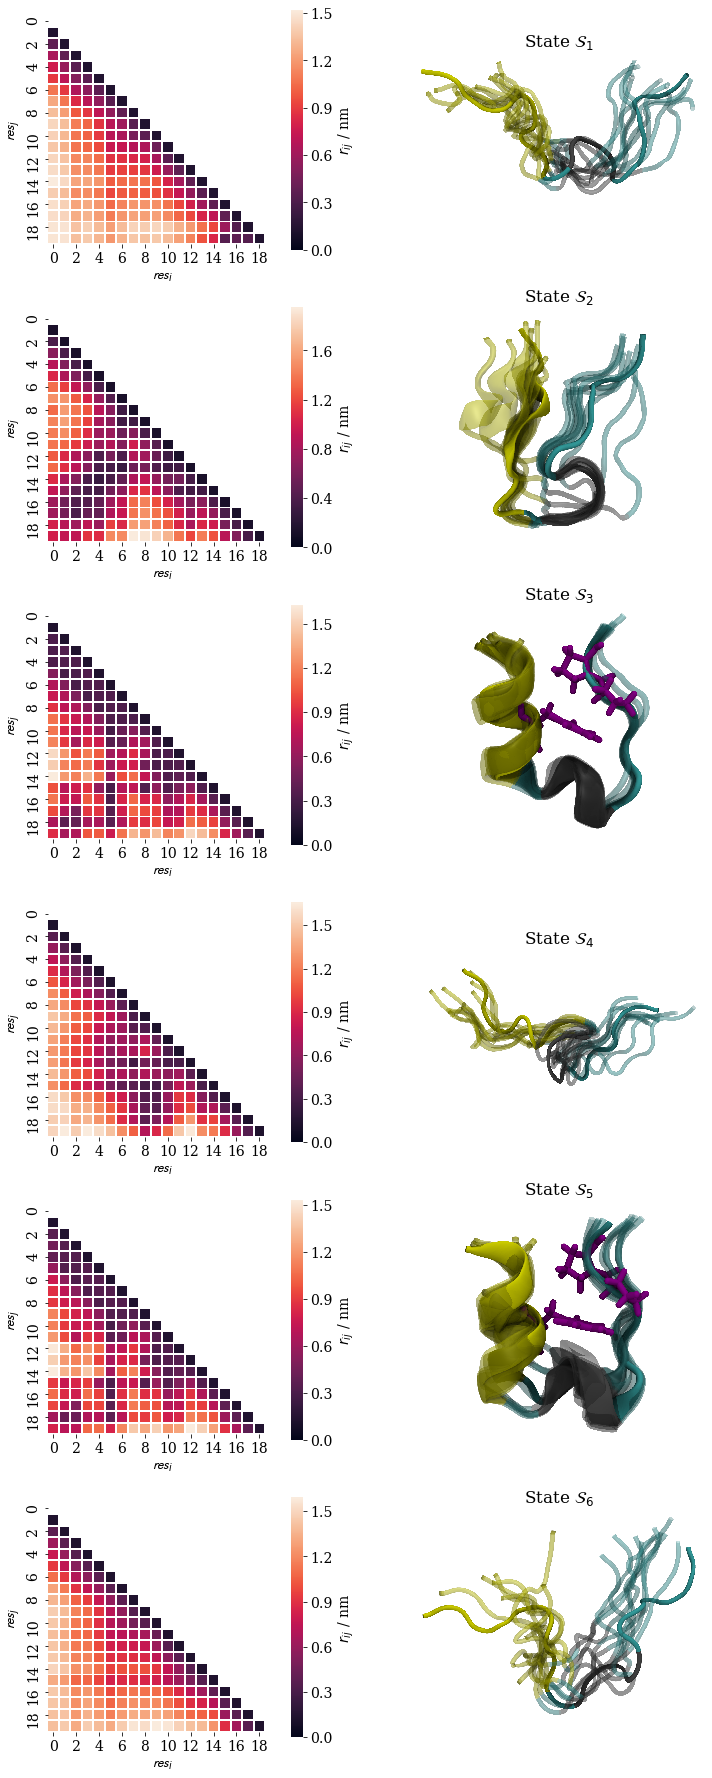

In [131]:
f, axes = plt.subplots(nstates, 2, figsize=(10, 25))

for i, ax in enumerate(axes.flat):
    if np.mod(i,2) == 1:
        ax.set_axis_off()
        ax.imshow(plt.imread("data/pcca{}.bmp".format(i//2+1)))
        ax.set_title(r"State $\mathcal{{S}}_{}$".format(i//2+1))
    else:
        #dmap = np.mean(get_state_atom_distmat(trj, metastable_traj, i//2), axis=0)
        dmat = np.mean(get_state_residue_distmat(trj, all_pairs, metastable_traj, i//2), axis=0)
        #cmat = distance_to_contact(dmat, 0, 0.5)
        mask = np.zeros_like(dmat, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True

        sns.heatmap(dmat, 
                    square=True, 
                    cmap=sns.cm.rocket, 
                    mask=mask, 
                    linewidths=.9, 
                    ax=ax, 
                    cbar_kws={"label" : r"$r_{ij}$ / nm"})

        ax.set_xlabel(r"$\mathcal{res}_i$")
        ax.set_ylabel(r"$\mathcal{res}_j$")

f.tight_layout()
plt.savefig("res_distance_mats.png", dpi=300)
plt.show()

### Conclusions and path forward 

After identifying the issues with Deng et al., we constructed a reasonable TICA projection + MSM. Our implied timescales are consistent with other literature, as is the identification of a single dominant eigenmode. The TICA and MSM can definitely be improved and optimized via grid search and VAMP2 scoring for validation. Given the discrepancy identified in Deng et al., I don't know if it's worth continuing with reproducing their model precisely. However, immediate paths forward include: 

- Coarse graining the MSM using PCCA++. Generating visualizations of discrete state ensembles.
- Quantitatively compare diffusion maps using geometric metrics and TICA coordinates. 
- Perform biased simulations once workstation is up and running.

## Diffusion map analysis

In [146]:
import dmaps as dm

In [147]:
stride = np.array(range(0,len(trj)))[::35]

In [148]:
dist = dm.DistanceMatrix(Y[stride])
dist.compute(metric=dm.metrics.euclidean)

In [197]:
dmap = dm.DiffusionMap(dist)
dmap.set_kernel_bandwidth(0.5)
dmap.compute(5, alpha=0.3)

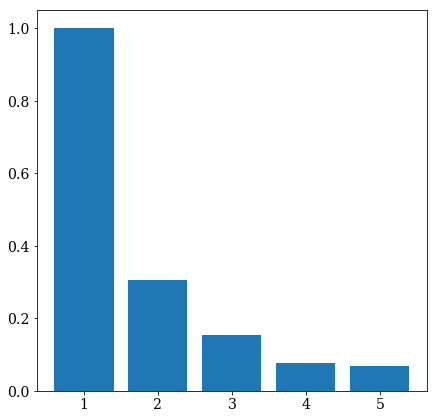

In [198]:
plt.figure(figsize=(7,7))
plt.bar(range(1,6), dmap.get_eigenvalues())
plt.show()

In [199]:
psi_1, psi_2, psi_3 = dmap.get_eigenvectors()[:,:3].T
psi_2 /= psi_1
psi_3 /= psi_1

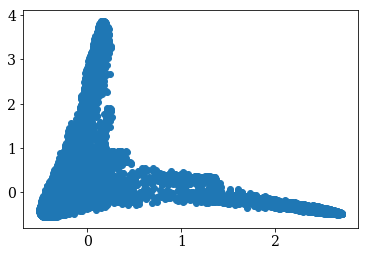

In [200]:
plt.scatter(psi_2, psi_3)

(<Figure size 1080x720 with 2 Axes>,
 {'mappable': <matplotlib.contour.QuadContourSet at 0x1b91432c18>,
  'cbar': <matplotlib.colorbar.Colorbar at 0x1b934f8ba8>})

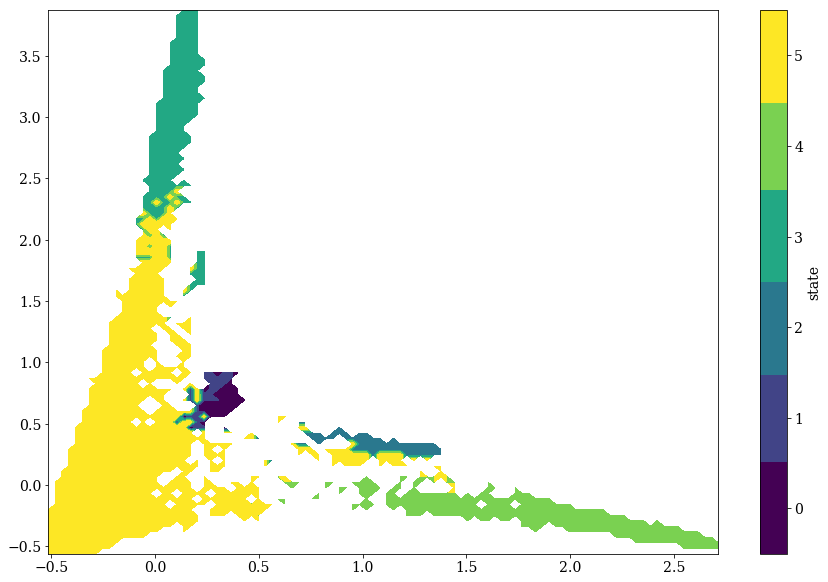

In [201]:
fig, ax = plt.subplots(figsize=(15,10))
pyemma.plots.plot_state_map(psi_2, psi_3, metastable_traj[stride], ax=ax)